In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pu_loss import PULoss, PULossWrapped
from utils import *
%matplotlib inline
%load_ext autoreload
%autoreload 2
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Load Data

In [2]:
DATA_DIR = os.path.join("data", "UCI HAR Dataset")


In [3]:
features_path = os.path.join(DATA_DIR, "features.txt")
features = pd.read_csv(features_path, sep='\s+', header=None, names=['index', 'feature_name'])['feature_name'].tolist()

In [4]:
X_train = pd.read_csv(
    os.path.join(DATA_DIR, "train", "X_train.txt"),
    sep='\s+',
    header=None,
)
X_test = pd.read_csv(
    os.path.join(DATA_DIR, "test", "X_test.txt"),
    sep='\s+',
    header=None,
)

y_train = pd.read_csv(
    os.path.join(DATA_DIR, "train", "y_train.txt"),
    header=None
)[0]
y_test = pd.read_csv(
    os.path.join(DATA_DIR, "test", "y_test.txt"),
    header=None
)[0]

In [5]:
pd.set_option('display.max_columns', None)
X_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,-0.567378,-0.744413,0.852947,0.685845,0.814263,-0.965523,-0.999945,-0.999863,-0.994612,-0.994231,-0.987614,-0.943220,-0.407747,-0.679338,-0.602122,0.929294,-0.853011,0.359910,-0.058526,0.256892,-0.224848,0.264106,-0.095246,0.278851,-0.465085,0.491936,-0.190884,0.376314,0.435129,0.660790,0.963396,-0.140840,0.115375,-0.985250,-0.981708,-0.877625,-0.985001,-0.984416,-0.894677,0.892055,-0.161265,0.124660,0.977436,-0.123213,0.056483,-0.375426,0.899469,-0.970905,-0.975510,-0.984325,-0.988849,-0.917743,-1.0,-1.0,0.113806,-0.590425,0.591146,-0.591773,0.592469,-0.745449,0.720862,-0.712372,0.711300,-0.995112,0.995675,-0.995668,0.991653,0.570222,0.439027,0.986913,0.077996,0.005001,-0.067831,-0.993519,-0.988360,-0.993575,-0.994488,-0.986207,-0.992818,-0.985180,-0.991994,-0.993119,0.989835,0.991957,0.990519,-0.993522,-0.999935,-0.999820,-0.999878,-0.994364,-0.986025,-0.989234,-0.819949,-0.793046,-0.888853,1.000000,-0.220747,0.636831,0.387644,0.241401,-0.052253,0.264177,0.373439,0.341778,-0.569791,0.265399,-0.477875,-0.385300,0.033644,-0.126511,-0.006101,-0.031365,0.107725,-0.985310,-0.976623,-0.992205,-0.984586,-0.976353,-0.992362,-0.867044,-0.933786,-0.747566,0.847308,0.914895,0.830841,-0.967184,-0.999578,-0.999354,-0.999763,-0.983438,-0.978614,-0.992966,0.082632,0.202268,-0.168757,0.096323,-0.274985,0.498644,-0.220317,1.000000,-0.972971,0.316655,0.375726,0.723399,-0.771112,0.690213,-0.331831,0.709584,0.134873,0.301099,-0.099167,-0.055517,-0.061986,-0.992111,-0.992519,-0.992055,-0.992165,-0.994942,-0.992619,-0.990156,-0.986743,-0.992042,0.994429,0.991756,0.989352,-0.994453,-0.999938,-0.999954,-0.999923,-0.992300,-0.996939,-0.992243,-0.589851,-0.688459,-0.572107,0.292376,-0.361998,0.405543,-0.039007,0.989284,-0.414560,0.391603,0.282251,0.927270,-0

In [6]:
activity_labels_df = pd.read_csv("data/UCI HAR Dataset/activity_labels.txt", sep='\s+', header=None, names=["id", "label"])
print(activity_labels_df)
labels = activity_labels_df["label"].to_list()

   id               label
0   1             WALKING
1   2    WALKING_UPSTAIRS
2   3  WALKING_DOWNSTAIRS
3   4             SITTING
4   5            STANDING
5   6              LAYING


In [7]:
y_train = y_train.to_numpy() - 1
y_test = y_test.to_numpy() - 1

In [8]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()


In [9]:
X_test, X_val, y_test, y_val = train_test_split(
    X_test, y_test, test_size=0.5, stratify=y_test, random_state=42
)

In [10]:
batch_size = 64
# Transform to binary 
positive_class = 2

y_train = np.where(y_train == positive_class, 1, 0)
y_val = np.where(y_val == positive_class, 1, 0)
y_test = np.where(y_test == positive_class, 1, 0)

X_train_tensor   = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_train_tensor   = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

X_train_tensor = X_train_tensor.view(X_train_tensor.shape[0], 1, -1)
X_val_tensor = X_val_tensor.view(X_val_tensor.shape[0], 1, -1)
X_test_tensor = X_test_tensor.view(X_test_tensor.shape[0], 1, -1)
print(X_train_tensor.shape, X_val_tensor.shape, X_test_tensor.shape)

train_dataset   = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset  = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader   = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # train 
val_loader  = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) # test

torch.Size([7352, 1, 561]) torch.Size([1474, 1, 561]) torch.Size([1473, 1, 561])


In [11]:
print(f"Positive ratio in train: {y_train.sum()/y_train.shape[0]}") 
print(f"Positive ratio in val: {y_val.sum()/y_val.shape[0]}") 
print(f"Positive ratio in test: {y_test.sum()/y_test.shape[0]}") 

Positive ratio in train: 0.13411316648531013
Positive ratio in val: 0.14246947082767977
Positive ratio in test: 0.1425661914460285


# Transform Data to PU Problem

In [12]:
unlabeled_fraction = 0.5
print(f"Positives before reduction, train: {y_train[y_train == 1].sum()}")
print(f"Positives before reduction, val: {y_val[y_val == 1].sum()}")
print(f"Positives before reduction, test: {y_test[y_test == 1].sum()}")

y_train_pu, unlabeled_idx_train = make_pu_labels(y_train, positive_class=1, unlabeled_fraction=unlabeled_fraction)
y_val_pu, unlabeled_idx_val = make_pu_labels(y_val, positive_class=1, unlabeled_fraction=unlabeled_fraction)
y_test_pu, unlabeled_idx_test = make_pu_labels(y_test, positive_class=1, unlabeled_fraction=unlabeled_fraction)

print(f"Positives after reduction, train: {y_train_pu[y_train_pu == 1].sum()}")
print(f"Positives after reduction, val: {y_val_pu[y_val_pu == 1].sum()}")
print(f"Positives after reduction, test: {y_test_pu[y_test_pu == 1].sum()}")


Positives before reduction, train: 986
Positives before reduction, val: 210
Positives before reduction, test: 210
Positives after reduction, train: 493
Positives after reduction, val: 105
Positives after reduction, test: 105


In [13]:
y_train_tensor_pu   = torch.tensor(y_train_pu, dtype=torch.long)
y_val_tensor_pu  = torch.tensor(y_val_pu, dtype=torch.long)
y_test_tensor_pu = torch.tensor(y_test_pu, dtype=torch.long)

train_dataset_pu   = TensorDataset(X_train_tensor, y_train_tensor_pu)
val_dataset_pu  = TensorDataset(X_val_tensor, y_val_tensor_pu)
test_dataset_pu = TensorDataset(X_test_tensor, y_test_tensor_pu)

train_loader_pu = DataLoader(train_dataset_pu, batch_size=batch_size, shuffle=True)
val_loader_pu   = DataLoader(val_dataset_pu, batch_size=batch_size, shuffle=False)
test_loader_pu  = DataLoader(test_dataset_pu, batch_size=batch_size, shuffle=False)


In [14]:

positive_prior = torch.tensor((y_train_pu).mean(), dtype=torch.float32)
positive_prior


tensor(0.0671)

# CNN + (weighted) CE Loss

In [18]:
in_channel = X_train_tensor.shape[1]
seq_length = X_train_tensor.shape[2]
n_output = len(y_train_tensor_pu.unique())-1
print(f'in_channel: {in_channel}, sequence_length: {seq_length}, n_output: {n_output}')
n_hidden = 64
num_epochs = 9
lr = 0.0001

in_channel: 1, sequence_length: 561, n_output: 1


In [19]:
from baseline import Conv_Net, train
model = Conv_Net(in_channel, seq_length, n_hidden, n_output=2, dropout=0.2)
model = model.to(device)
print(model)

Conv_Net(
  (conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=17920, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
  (features): Sequential(
    (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU()
    (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.2, inplace=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=17920, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=2, bias=True)
  )
)


In [22]:
from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(y_train_pu)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train_pu)
ce_weight = torch.tensor(weights, dtype=torch.float32, device=device)
criterion = nn.CrossEntropyLoss(weight=ce_weight)
ce_weight


tensor([0.5359, 7.4564], device='cuda:0')

In [23]:
import torch
import numpy as np
from collections import Counter

# === 1️⃣ Check percentage of positives in train_loader_pu ===
def check_train_loader_pu(loader):
    n_total = 0
    n_pos = 0
    all_labels = []
    for batch in loader:
        # Adjust if your dataloader returns dicts
        if isinstance(batch, (list, tuple)):
            _, labels = batch
        elif isinstance(batch, dict):
            labels = batch["labels"]
        else:
            raise RuntimeError("Unknown batch format in loader")

        if torch.is_tensor(labels):
            labels = labels.detach().cpu().numpy().ravel()
        else:
            labels = np.asarray(labels).ravel()

        n_total += len(labels)
        n_pos += (labels == 1).sum()
        all_labels.extend(labels.tolist())

    pct_pos = 100.0 * n_pos / n_total if n_total > 0 else float("nan")
    print("=== Train Loader (PU) Check ===")
    print(f"Total samples: {n_total}")
    print(f"Positives (==1): {n_pos} ({pct_pos:.2f}%)")
    print(f"Unique labels: {np.unique(all_labels)}\n")

check_train_loader_pu(train_loader_pu)


=== Train Loader (PU) Check ===
Total samples: 7352
Positives (==1): 493 (6.71%)
Unique labels: [0 1]



In [22]:
model.load_state_dict(torch.load("models/har_cnn_wCE.pth", weights_only=True))

<All keys matched successfully>

In [24]:
model = train(model, criterion, train_loader_pu, val_loader, lr, num_epochs, device)

100%|██████████| 115/115 [00:10<00:00, 11.17it/s]


Epoch [1/9], tr_loss: 0.37609 tr_acc: 0.79992 test_loss: 0.35389, test_acc: 0.93080


100%|██████████| 115/115 [00:00<00:00, 396.54it/s]


Epoch [2/9], tr_loss: 0.25988 tr_acc: 0.87242 test_loss: 0.21478, test_acc: 0.93962


100%|██████████| 115/115 [00:00<00:00, 402.82it/s]


Epoch [3/9], tr_loss: 0.21524 tr_acc: 0.90588 test_loss: 0.17658, test_acc: 0.96744


100%|██████████| 115/115 [00:00<00:00, 401.35it/s]


Epoch [4/9], tr_loss: 0.19008 tr_acc: 0.91649 test_loss: 0.14526, test_acc: 0.96879


100%|██████████| 115/115 [00:00<00:00, 402.39it/s]


Epoch [5/9], tr_loss: 0.17759 tr_acc: 0.92233 test_loss: 0.18435, test_acc: 0.97761


100%|██████████| 115/115 [00:00<00:00, 400.76it/s]


Epoch [6/9], tr_loss: 0.16221 tr_acc: 0.92723 test_loss: 0.16655, test_acc: 0.97897


100%|██████████| 115/115 [00:00<00:00, 387.05it/s]


Epoch [7/9], tr_loss: 0.16080 tr_acc: 0.92750 test_loss: 0.18511, test_acc: 0.98100


100%|██████████| 115/115 [00:00<00:00, 398.02it/s]


Epoch [8/9], tr_loss: 0.15064 tr_acc: 0.92968 test_loss: 0.30135, test_acc: 0.97490


100%|██████████| 115/115 [00:00<00:00, 399.48it/s]


Epoch [9/9], tr_loss: 0.14922 tr_acc: 0.93077 test_loss: 0.19122, test_acc: 0.98100


In [35]:
model.eval()
out_train = model(X_train_tensor.to(device)).cpu()
preds_train = torch.max(out_train, 1)[1]

print(classification_report(y_train_pu, preds_train, digits=4))
print(confusion_matrix(y_train_pu, preds_train))

              precision    recall  f1-score   support

           0     1.0000    0.9246    0.9608      6859
           1     0.4881    1.0000    0.6560       493

    accuracy                         0.9297      7352
   macro avg     0.7441    0.9623    0.8084      7352
weighted avg     0.9657    0.9297    0.9404      7352

[[6342  517]
 [   0  493]]


In [36]:
print(classification_report(y_train, preds_train, digits=4))
print(confusion_matrix(y_train, preds_train))

              precision    recall  f1-score   support

           0     0.9998    0.9961    0.9980      6366
           1     0.9752    0.9990    0.9870       986

    accuracy                         0.9965      7352
   macro avg     0.9875    0.9975    0.9925      7352
weighted avg     0.9965    0.9965    0.9965      7352

[[6341   25]
 [   1  985]]


In [27]:
out_val = model(X_val_tensor.to(device)).cpu()
preds_val = torch.max(out_val, 1)[1]

print(classification_report(y_val_pu, preds_val, digits=4))
print(confusion_matrix(y_val_pu, preds_val))

              precision    recall  f1-score   support

           0     0.9929    0.9240    0.9572      1369
           1     0.4800    0.9143    0.6295       105

    accuracy                         0.9233      1474
   macro avg     0.7365    0.9192    0.7934      1474
weighted avg     0.9564    0.9233    0.9339      1474

[[1265  104]
 [   9   96]]


In [28]:
print(classification_report(y_val, preds_val, digits=4))
print(confusion_matrix(y_val, preds_val))

              precision    recall  f1-score   support

           0     0.9851    0.9929    0.9890      1264
           1     0.9550    0.9095    0.9317       210

    accuracy                         0.9810      1474
   macro avg     0.9700    0.9512    0.9603      1474
weighted avg     0.9808    0.9810    0.9808      1474

[[1255    9]
 [  19  191]]


In [29]:
out_test = model(X_test_tensor.to(device)).cpu()
preds_test = torch.max(out_test, 1)[1]

print(classification_report(y_test_pu, preds_test, digits=4))
print(confusion_matrix(y_test_pu, preds_test))

              precision    recall  f1-score   support

           0     0.9945    0.9269    0.9595      1368
           1     0.4949    0.9333    0.6469       105

    accuracy                         0.9274      1473
   macro avg     0.7447    0.9301    0.8032      1473
weighted avg     0.9589    0.9274    0.9372      1473

[[1268  100]
 [   7   98]]


In [30]:
print(classification_report(y_test, preds_test, digits=4))
print(confusion_matrix(y_test, preds_test))

              precision    recall  f1-score   support

           0     0.9867    0.9960    0.9913      1263
           1     0.9747    0.9190    0.9461       210

    accuracy                         0.9851      1473
   macro avg     0.9807    0.9575    0.9687      1473
weighted avg     0.9850    0.9851    0.9849      1473

[[1258    5]
 [  17  193]]


In [31]:
# Observe the unmarked positive samples and determine in how many places the prediction matches true labels.
print("Train")
correct_preds_num_tr = (preds_train[unlabeled_idx_train] == y_train[unlabeled_idx_train]).sum()
print(f"Total number of true positive sampels:{(y_train==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_train)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tr}\n\
In percentage: {(correct_preds_num_tr/len(unlabeled_idx_train)):.4f}")
print("Test")
correct_preds_num_tst = (preds_test[unlabeled_idx_test] == y_test[unlabeled_idx_test]).sum()
print(f"Total number of true positive sampels:{(y_test==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_test)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tst}\n\
In percentage: {(correct_preds_num_tst/len(unlabeled_idx_test)):.4f}")
print("Val")
correct_preds_num_val = (preds_val[unlabeled_idx_val] == y_val[unlabeled_idx_val]).sum()
print(f"Total number of true positive sampels:{(y_val==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_val)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_val}\n\
In percentage: {(correct_preds_num_val/len(unlabeled_idx_val)):.4f}")

Train
Total number of true positive sampels:986
Total number of unmarked positive sampels: 493
Number of unmarked samples correctly predicted as positive: 492
In percentage: 0.9980
Test
Total number of true positive sampels:210
Total number of unmarked positive sampels: 105
Number of unmarked samples correctly predicted as positive: 95
In percentage: 0.9048
Val
Total number of true positive sampels:210
Total number of unmarked positive sampels: 105
Number of unmarked samples correctly predicted as positive: 95
In percentage: 0.9048


In [37]:
torch.save(model.state_dict(), "models/har_cnn_wCE.pth")

# CNN + (unweighted) CE Loss

In [49]:
from baseline import Conv_Net, train
model = Conv_Net(in_channel, seq_length, n_hidden, n_output=2, dropout=0.2)
model = model.to(device)
criterion = nn.CrossEntropyLoss()

In [50]:
model = train(model, criterion, train_loader_pu, val_loader, 0.0001, 15, device)

100%|██████████| 115/115 [00:00<00:00, 409.85it/s]


Epoch [1/15], tr_loss: 0.21381 tr_acc: 0.92560 test_loss: 0.28102, test_acc: 0.85753


100%|██████████| 115/115 [00:00<00:00, 410.25it/s]


Epoch [2/15], tr_loss: 0.14512 tr_acc: 0.93294 test_loss: 0.27985, test_acc: 0.85753


100%|██████████| 115/115 [00:00<00:00, 412.66it/s]


Epoch [3/15], tr_loss: 0.12919 tr_acc: 0.93512 test_loss: 0.17839, test_acc: 0.91113


100%|██████████| 115/115 [00:00<00:00, 413.71it/s]


Epoch [4/15], tr_loss: 0.12368 tr_acc: 0.93390 test_loss: 0.21626, test_acc: 0.89077


100%|██████████| 115/115 [00:00<00:00, 412.32it/s]


Epoch [5/15], tr_loss: 0.11627 tr_acc: 0.93322 test_loss: 0.22011, test_acc: 0.86839


100%|██████████| 115/115 [00:00<00:00, 411.05it/s]


Epoch [6/15], tr_loss: 0.11032 tr_acc: 0.93403 test_loss: 0.18108, test_acc: 0.89620


100%|██████████| 115/115 [00:00<00:00, 410.77it/s]


Epoch [7/15], tr_loss: 0.10731 tr_acc: 0.93526 test_loss: 0.14344, test_acc: 0.93962


100%|██████████| 115/115 [00:00<00:00, 410.15it/s]


Epoch [8/15], tr_loss: 0.10420 tr_acc: 0.93430 test_loss: 0.13850, test_acc: 0.93080


100%|██████████| 115/115 [00:00<00:00, 407.55it/s]


Epoch [9/15], tr_loss: 0.10305 tr_acc: 0.93430 test_loss: 0.16656, test_acc: 0.86703


100%|██████████| 115/115 [00:00<00:00, 408.47it/s]


Epoch [10/15], tr_loss: 0.10252 tr_acc: 0.93458 test_loss: 0.18101, test_acc: 0.88128


100%|██████████| 115/115 [00:00<00:00, 409.70it/s]


Epoch [11/15], tr_loss: 0.09904 tr_acc: 0.93757 test_loss: 0.19673, test_acc: 0.86160


100%|██████████| 115/115 [00:00<00:00, 407.33it/s]


Epoch [12/15], tr_loss: 0.09780 tr_acc: 0.93662 test_loss: 0.16737, test_acc: 0.92537


100%|██████████| 115/115 [00:00<00:00, 405.93it/s]


Epoch [13/15], tr_loss: 0.09642 tr_acc: 0.94056 test_loss: 0.16830, test_acc: 0.89824


100%|██████████| 115/115 [00:00<00:00, 408.85it/s]


Epoch [14/15], tr_loss: 0.09704 tr_acc: 0.93852 test_loss: 0.13103, test_acc: 0.93894


100%|██████████| 115/115 [00:00<00:00, 400.98it/s]


Epoch [15/15], tr_loss: 0.09571 tr_acc: 0.93838 test_loss: 0.14978, test_acc: 0.92130


In [67]:
model.load_state_dict(torch.load("models/har_cnn_CE.pth", weights_only=True))

<All keys matched successfully>

In [68]:
model.eval()
out_train = model(X_train_tensor.to(device)).cpu()
preds_train = torch.max(out_train, 1)[1]

print(classification_report(y_train_pu, preds_train, digits=4))
print(confusion_matrix(y_train_pu, preds_train))

              precision    recall  f1-score   support

           0     0.9796    0.9612    0.9703      6859
           1     0.5723    0.7221    0.6386       493

    accuracy                         0.9452      7352
   macro avg     0.7760    0.8417    0.8045      7352
weighted avg     0.9523    0.9452    0.9481      7352

[[6593  266]
 [ 137  356]]


In [69]:
print(classification_report(y_train, preds_train, digits=4))
print(confusion_matrix(y_train, preds_train))

              precision    recall  f1-score   support

           0     0.9459    1.0000    0.9722      6366
           1     1.0000    0.6308    0.7736       986

    accuracy                         0.9505      7352
   macro avg     0.9730    0.8154    0.8729      7352
weighted avg     0.9532    0.9505    0.9456      7352

[[6366    0]
 [ 364  622]]


In [70]:
out_val = model(X_val_tensor.to(device)).cpu()
preds_val = torch.max(out_val, 1)[1]

print(classification_report(y_val_pu, preds_val, digits=4))
print(confusion_matrix(y_val_pu, preds_val))

              precision    recall  f1-score   support

           0     0.9550    0.9613    0.9581      1369
           1     0.4479    0.4095    0.4279       105

    accuracy                         0.9220      1474
   macro avg     0.7015    0.6854    0.6930      1474
weighted avg     0.9189    0.9220    0.9204      1474

[[1316   53]
 [  62   43]]


In [71]:
print(classification_report(y_val, preds_val, digits=4))
print(confusion_matrix(y_val, preds_val))

              precision    recall  f1-score   support

           0     0.9165    0.9992    0.9561      1264
           1     0.9896    0.4524    0.6209       210

    accuracy                         0.9213      1474
   macro avg     0.9531    0.7258    0.7885      1474
weighted avg     0.9270    0.9213    0.9083      1474

[[1263    1]
 [ 115   95]]


In [72]:
out_test = model(X_test_tensor.to(device)).cpu()
preds_test = torch.max(out_test, 1)[1]

print(classification_report(y_test_pu, preds_test, digits=4))
print(confusion_matrix(y_test_pu, preds_test))

              precision    recall  f1-score   support

           0     0.9566    0.9656    0.9611      1368
           1     0.4891    0.4286    0.4569       105

    accuracy                         0.9274      1473
   macro avg     0.7228    0.6971    0.7090      1473
weighted avg     0.9232    0.9274    0.9251      1473

[[1321   47]
 [  60   45]]


In [73]:
print(classification_report(y_test, preds_test, digits=4))
print(confusion_matrix(y_test, preds_test))

              precision    recall  f1-score   support

           0     0.9146    1.0000    0.9554      1263
           1     1.0000    0.4381    0.6093       210

    accuracy                         0.9199      1473
   macro avg     0.9573    0.7190    0.7823      1473
weighted avg     0.9267    0.9199    0.9060      1473

[[1263    0]
 [ 118   92]]


In [74]:
# Observe the unmarked positive samples and determine in how many places the prediction matches true labels.
print("Train")
correct_preds_num_tr = (preds_train[unlabeled_idx_train] == y_train[unlabeled_idx_train]).sum()
print(f"Total number of true positive sampels:{(y_train==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_train)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tr}\n\
In percentage: {(correct_preds_num_tr/len(unlabeled_idx_train)):.4f}")
print("Test")
correct_preds_num_tst = (preds_test[unlabeled_idx_test] == y_test[unlabeled_idx_test]).sum()
print(f"Total number of true positive sampels:{(y_test==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_test)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tst}\n\
In percentage: {(correct_preds_num_tst/len(unlabeled_idx_test)):.4f}")
print("Val")
correct_preds_num_val = (preds_val[unlabeled_idx_val] == y_val[unlabeled_idx_val]).sum()
print(f"Total number of true positive sampels:{(y_val==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_val)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_val}\n\
In percentage: {(correct_preds_num_val/len(unlabeled_idx_val)):.4f}")

Train
Total number of true positive sampels:986
Total number of unmarked positive sampels: 493
Number of unmarked samples correctly predicted as positive: 266
In percentage: 0.5396
Test
Total number of true positive sampels:210
Total number of unmarked positive sampels: 105
Number of unmarked samples correctly predicted as positive: 47
In percentage: 0.4476
Val
Total number of true positive sampels:210
Total number of unmarked positive sampels: 105
Number of unmarked samples correctly predicted as positive: 52
In percentage: 0.4952


In [58]:
torch.save(model.state_dict(), "models/har_cnn_CE.pth")

# CNN + AsymLoss

In [24]:
n_hidden = 64
num_epochs = 20
lr = 0.0001
model = Conv_Net(in_channel, seq_length, n_hidden, n_output=2)
model = model.to(device)

In [25]:
from pu_loss import PUAsymLoss_CE
criterion = PUAsymLoss_CE(gamma=0.1)


In [39]:
model = train(model, criterion, train_loader_pu, test_loader, lr, num_epochs, device)

100%|██████████| 115/115 [00:00<00:00, 277.23it/s]


Epoch [1/20], tr_loss: 0.56764 tr_acc: 0.72661 test_loss: 0.35393, test_acc: 0.86354


100%|██████████| 115/115 [00:00<00:00, 283.08it/s]


Epoch [2/20], tr_loss: 0.32674 tr_acc: 0.84249 test_loss: 0.25590, test_acc: 0.96809


100%|██████████| 115/115 [00:00<00:00, 272.51it/s]


Epoch [3/20], tr_loss: 0.25062 tr_acc: 0.88289 test_loss: 0.16397, test_acc: 0.97488


100%|██████████| 115/115 [00:00<00:00, 281.97it/s]


Epoch [4/20], tr_loss: 0.19635 tr_acc: 0.90288 test_loss: 0.18131, test_acc: 0.97692


100%|██████████| 115/115 [00:00<00:00, 281.52it/s]


Epoch [5/20], tr_loss: 0.15845 tr_acc: 0.91050 test_loss: 0.11814, test_acc: 0.97963


100%|██████████| 115/115 [00:00<00:00, 272.75it/s]


Epoch [6/20], tr_loss: 0.16249 tr_acc: 0.90887 test_loss: 0.05080, test_acc: 0.98235


100%|██████████| 115/115 [00:00<00:00, 281.45it/s]


Epoch [7/20], tr_loss: 0.12154 tr_acc: 0.91853 test_loss: 0.05831, test_acc: 0.98710


100%|██████████| 115/115 [00:00<00:00, 283.24it/s]


Epoch [8/20], tr_loss: 0.11384 tr_acc: 0.92029 test_loss: 0.05382, test_acc: 0.98846


100%|██████████| 115/115 [00:00<00:00, 271.91it/s]


Epoch [9/20], tr_loss: 0.10430 tr_acc: 0.92274 test_loss: 0.19064, test_acc: 0.97760


100%|██████████| 115/115 [00:00<00:00, 279.34it/s]


Epoch [10/20], tr_loss: 0.10299 tr_acc: 0.92233 test_loss: 0.02380, test_acc: 0.98303


100%|██████████| 115/115 [00:00<00:00, 283.60it/s]


Epoch [11/20], tr_loss: 0.09874 tr_acc: 0.92478 test_loss: 0.08221, test_acc: 0.98371


100%|██████████| 115/115 [00:00<00:00, 271.83it/s]


Epoch [12/20], tr_loss: 0.09386 tr_acc: 0.92533 test_loss: 0.04251, test_acc: 0.98642


100%|██████████| 115/115 [00:00<00:00, 276.92it/s]


Epoch [13/20], tr_loss: 0.08524 tr_acc: 0.92696 test_loss: 0.06417, test_acc: 0.98574


100%|██████████| 115/115 [00:00<00:00, 282.92it/s]


Epoch [14/20], tr_loss: 0.08881 tr_acc: 0.92696 test_loss: 0.13466, test_acc: 0.98099


100%|██████████| 115/115 [00:00<00:00, 272.19it/s]


Epoch [15/20], tr_loss: 0.08325 tr_acc: 0.92669 test_loss: 0.02867, test_acc: 0.98778


100%|██████████| 115/115 [00:00<00:00, 278.24it/s]


Epoch [16/20], tr_loss: 0.08530 tr_acc: 0.92669 test_loss: 0.17737, test_acc: 0.97624


100%|██████████| 115/115 [00:00<00:00, 282.88it/s]


Epoch [17/20], tr_loss: 0.09922 tr_acc: 0.92369 test_loss: 0.26017, test_acc: 0.97556


100%|██████████| 115/115 [00:00<00:00, 271.97it/s]


Epoch [18/20], tr_loss: 0.07831 tr_acc: 0.92859 test_loss: 0.10061, test_acc: 0.98439


100%|██████████| 115/115 [00:00<00:00, 278.61it/s]


Epoch [19/20], tr_loss: 0.07664 tr_acc: 0.92913 test_loss: 0.17332, test_acc: 0.98031


100%|██████████| 115/115 [00:00<00:00, 282.49it/s]

Epoch [20/20], tr_loss: 0.07768 tr_acc: 0.92900 test_loss: 0.08023, test_acc: 0.98642


In [26]:
model.load_state_dict(torch.load("models/har_cnn_asymloss_0.1.pth", weights_only=True))

<All keys matched successfully>

In [27]:
model.eval()
out_train = model(X_train_tensor.to(device)).cpu()
preds_train = torch.max(out_train, 1)[1]

print(classification_report(y_train_pu, preds_train, digits=4))
print(confusion_matrix(y_train_pu, preds_train))

              precision    recall  f1-score   support

           0     1.0000    0.9261    0.9616      6859
           1     0.4930    1.0000    0.6604       493

    accuracy                         0.9310      7352
   macro avg     0.7465    0.9630    0.8110      7352
weighted avg     0.9660    0.9310    0.9414      7352

[[6352  507]
 [   0  493]]


In [41]:
print(classification_report(y_train, preds_train, digits=4))
print(confusion_matrix(y_train, preds_train))

              precision    recall  f1-score   support

           0     0.9997    0.9975    0.9986      6366
           1     0.9840    0.9980    0.9909       986

    accuracy                         0.9976      7352
   macro avg     0.9918    0.9977    0.9948      7352
weighted avg     0.9976    0.9976    0.9976      7352

[[6350   16]
 [   2  984]]


In [42]:
out_val = model(X_val_tensor.to(device)).cpu()
preds_val = torch.max(out_val, 1)[1]

print(classification_report(y_val_pu, preds_val, digits=4))
print(confusion_matrix(y_val_pu, preds_val))

              precision    recall  f1-score   support

           0     0.9953    0.9218    0.9571      1369
           1     0.4806    0.9429    0.6367       105

    accuracy                         0.9233      1474
   macro avg     0.7379    0.9323    0.7969      1474
weighted avg     0.9586    0.9233    0.9343      1474

[[1262  107]
 [   6   99]]


In [43]:
print(classification_report(y_val, preds_val, digits=4))
print(confusion_matrix(y_val, preds_val))

              precision    recall  f1-score   support

           0     0.9882    0.9913    0.9897      1264
           1     0.9466    0.9286    0.9375       210

    accuracy                         0.9824      1474
   macro avg     0.9674    0.9599    0.9636      1474
weighted avg     0.9822    0.9824    0.9823      1474

[[1253   11]
 [  15  195]]


In [44]:
out_test = model(X_test_tensor.to(device)).cpu()
preds_test = torch.max(out_test, 1)[1]

print(classification_report(y_test_pu, preds_test, digits=4))
print(confusion_matrix(y_test_pu, preds_test))

              precision    recall  f1-score   support

           0     0.9945    0.9240    0.9579      1368
           1     0.4851    0.9333    0.6384       105

    accuracy                         0.9246      1473
   macro avg     0.7398    0.9287    0.7982      1473
weighted avg     0.9582    0.9246    0.9352      1473

[[1264  104]
 [   7   98]]


In [45]:
print(classification_report(y_test, preds_test, digits=4))
print(confusion_matrix(y_test, preds_test))

              precision    recall  f1-score   support

           0     0.9890    0.9952    0.9921      1263
           1     0.9703    0.9333    0.9515       210

    accuracy                         0.9864      1473
   macro avg     0.9796    0.9643    0.9718      1473
weighted avg     0.9863    0.9864    0.9863      1473

[[1257    6]
 [  14  196]]


In [46]:
# Observe the unmarked positive samples and determine in how many places the prediction matches true labels.
print("Train")
correct_preds_num_tr = (preds_train[unlabeled_idx_train] == y_train[unlabeled_idx_train]).sum()
print(f"Total number of true positive sampels:{(y_train==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_train)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tr}\n\
In percentage: {(correct_preds_num_tr/len(unlabeled_idx_train)):.4f}")
print("Test")
correct_preds_num_tst = (preds_test[unlabeled_idx_test] == y_test[unlabeled_idx_test]).sum()
print(f"Total number of true positive sampels:{(y_test==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_test)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tst}\n\
In percentage: {(correct_preds_num_tst/len(unlabeled_idx_test)):.4f}")
print("Val")
correct_preds_num_val = (preds_val[unlabeled_idx_val] == y_val[unlabeled_idx_val]).sum()
print(f"Total number of true positive sampels:{(y_val==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_val)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_val}\n\
In percentage: {(correct_preds_num_val/len(unlabeled_idx_val)):.4f}")

Train
Total number of true positive sampels:986
Total number of unmarked positive sampels: 493
Number of unmarked samples correctly predicted as positive: 491
In percentage: 0.9959
Test
Total number of true positive sampels:210
Total number of unmarked positive sampels: 105
Number of unmarked samples correctly predicted as positive: 98
In percentage: 0.9333
Val
Total number of true positive sampels:210
Total number of unmarked positive sampels: 105
Number of unmarked samples correctly predicted as positive: 96
In percentage: 0.9143


In [115]:
torch.save(model.state_dict(), "models/har_cnn_asymloss_0.1.pth")

# CNN + PU Loss

In [17]:
from pu_loss import PULoss
criterion = PULoss(prior=1*positive_prior)

In [18]:
from baseline import train, Conv_Net
lr = 0.00005
num_epochs = 20
model = Conv_Net(in_channel, seq_length, n_hidden, n_output=1, dropout=0.2)
#model.load_state_dict(torch.load("models/har_cnn_pu.pth"))
model = model.to(device)

/home/darosali/btl/.myenv2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
model = train(model, criterion, train_loader_pu, test_loader, lr, num_epochs, device)

  0%|          | 0/115 [00:00<?, ?it/s]/home/darosali/btl/har/har-pu-learning/pu_loss.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.prior = torch.tensor(self.prior, device=inp.device)
100%|██████████| 115/115 [00:03<00:00, 33.30it/s]


Epoch [1/20], tr_loss: 0.21407 tr_acc: 0.92696 test_loss: 0.14761, test_acc: 0.85743


100%|██████████| 115/115 [00:00<00:00, 261.18it/s]


Epoch [2/20], tr_loss: 0.13650 tr_acc: 0.93158 test_loss: 0.10560, test_acc: 0.88934


100%|██████████| 115/115 [00:00<00:00, 262.66it/s]


Epoch [3/20], tr_loss: 0.10994 tr_acc: 0.93362 test_loss: 0.09372, test_acc: 0.89002


100%|██████████| 115/115 [00:00<00:00, 263.67it/s]


Epoch [4/20], tr_loss: 0.09418 tr_acc: 0.93349 test_loss: 0.08952, test_acc: 0.89070


100%|██████████| 115/115 [00:00<00:00, 264.49it/s]


Epoch [5/20], tr_loss: 0.08868 tr_acc: 0.93376 test_loss: 0.06996, test_acc: 0.90292


100%|██████████| 115/115 [00:00<00:00, 263.69it/s]


Epoch [6/20], tr_loss: 0.08572 tr_acc: 0.93267 test_loss: 0.06396, test_acc: 0.90360


100%|██████████| 115/115 [00:00<00:00, 261.21it/s]


Epoch [7/20], tr_loss: 0.08171 tr_acc: 0.93580 test_loss: 0.05258, test_acc: 0.92396


100%|██████████| 115/115 [00:00<00:00, 262.81it/s]


Epoch [8/20], tr_loss: 0.07642 tr_acc: 0.93308 test_loss: 0.05575, test_acc: 0.91921


100%|██████████| 115/115 [00:00<00:00, 262.70it/s]


Epoch [9/20], tr_loss: 0.07340 tr_acc: 0.93648 test_loss: 0.04715, test_acc: 0.92940


100%|██████████| 115/115 [00:00<00:00, 262.13it/s]


Epoch [10/20], tr_loss: 0.07194 tr_acc: 0.93254 test_loss: 0.03664, test_acc: 0.95180


100%|██████████| 115/115 [00:00<00:00, 262.17it/s]


Epoch [11/20], tr_loss: 0.06949 tr_acc: 0.93022 test_loss: 0.03759, test_acc: 0.94637


100%|██████████| 115/115 [00:00<00:00, 260.70it/s]


Epoch [12/20], tr_loss: 0.06700 tr_acc: 0.93403 test_loss: 0.04539, test_acc: 0.92872


100%|██████████| 115/115 [00:00<00:00, 262.94it/s]


Epoch [13/20], tr_loss: 0.06512 tr_acc: 0.93199 test_loss: 0.03835, test_acc: 0.93618


100%|██████████| 115/115 [00:00<00:00, 263.16it/s]


Epoch [14/20], tr_loss: 0.06311 tr_acc: 0.93267 test_loss: 0.03634, test_acc: 0.94162


100%|██████████| 115/115 [00:00<00:00, 263.00it/s]


Epoch [15/20], tr_loss: 0.06214 tr_acc: 0.93308 test_loss: 0.03742, test_acc: 0.94026


100%|██████████| 115/115 [00:00<00:00, 263.24it/s]


Epoch [16/20], tr_loss: 0.06063 tr_acc: 0.93322 test_loss: 0.03516, test_acc: 0.94501


100%|██████████| 115/115 [00:00<00:00, 263.06it/s]


Epoch [17/20], tr_loss: 0.05841 tr_acc: 0.93226 test_loss: 0.04306, test_acc: 0.93143


100%|██████████| 115/115 [00:00<00:00, 263.26it/s]


Epoch [18/20], tr_loss: 0.05610 tr_acc: 0.93390 test_loss: 0.03627, test_acc: 0.94433


100%|██████████| 115/115 [00:00<00:00, 263.28it/s]


Epoch [19/20], tr_loss: 0.05605 tr_acc: 0.93335 test_loss: 0.03593, test_acc: 0.94297


100%|██████████| 115/115 [00:00<00:00, 261.82it/s]

Epoch [20/20], tr_loss: 0.05430 tr_acc: 0.93512 test_loss: 0.02695, test_acc: 0.95384


In [27]:
model.load_state_dict(torch.load("models/har_cnn_uPU.pth", weights_only=True))

<All keys matched successfully>

In [28]:
model.eval()
out_train = model(X_train_tensor.to(device)).cpu()
preds_train = (out_train.squeeze() > 0).long().clone().detach()

print(classification_report(y_train_pu, preds_train, digits=4))
print(confusion_matrix(y_train_pu, preds_train))

              precision    recall  f1-score   support

           0     0.9941    0.9309    0.9615      6859
           1     0.4898    0.9229    0.6399       493

    accuracy                         0.9304      7352
   macro avg     0.7419    0.9269    0.8007      7352
weighted avg     0.9603    0.9304    0.9399      7352

[[6385  474]
 [  38  455]]


In [29]:
print(classification_report(y_train, preds_train, digits=4))
print(confusion_matrix(y_train, preds_train))

              precision    recall  f1-score   support

           0     0.9896    0.9984    0.9940      6366
           1     0.9892    0.9320    0.9598       986

    accuracy                         0.9895      7352
   macro avg     0.9894    0.9652    0.9769      7352
weighted avg     0.9895    0.9895    0.9894      7352

[[6356   10]
 [  67  919]]


In [30]:
model.eval()
out_val = model(X_val_tensor.to(device)).cpu()
preds_val = (out_val.squeeze() > 0).long().clone().detach()

print(classification_report(y_val_pu, preds_val.cpu().detach().numpy(), digits=4))
print(confusion_matrix(y_val_pu, preds_val.cpu().detach().numpy()))

              precision    recall  f1-score   support

           0     0.9816    0.9372    0.9589      1369
           1     0.4850    0.7714    0.5956       105

    accuracy                         0.9254      1474
   macro avg     0.7333    0.8543    0.7772      1474
weighted avg     0.9463    0.9254    0.9330      1474

[[1283   86]
 [  24   81]]


In [31]:
print(classification_report(y_val, preds_val.cpu().detach().numpy(), digits=4))
print(confusion_matrix(y_val, preds_val.cpu().detach().numpy()))

              precision    recall  f1-score   support

           0     0.9656    0.9984    0.9817      1264
           1     0.9880    0.7857    0.8753       210

    accuracy                         0.9681      1474
   macro avg     0.9768    0.8921    0.9285      1474
weighted avg     0.9688    0.9681    0.9666      1474

[[1262    2]
 [  45  165]]


In [32]:
out_test = model(X_test_tensor.to(device)).cpu()
preds_test = (out_test.squeeze() > 0).long().clone().detach()


print(classification_report(y_test_pu, preds_test.cpu().detach().numpy(), digits=4))
print(confusion_matrix(y_test_pu, preds_test.cpu().detach().numpy()))

              precision    recall  f1-score   support

           0     0.9839    0.9408    0.9619      1368
           1     0.5091    0.8000    0.6222       105

    accuracy                         0.9308      1473
   macro avg     0.7465    0.8704    0.7921      1473
weighted avg     0.9501    0.9308    0.9377      1473

[[1287   81]
 [  21   84]]


In [33]:
print(classification_report(y_test, preds_test.cpu().detach().numpy(), digits=4))
print(confusion_matrix(y_test, preds_test.cpu().detach().numpy()))

              precision    recall  f1-score   support

           0     0.9641    0.9984    0.9809      1263
           1     0.9879    0.7762    0.8693       210

    accuracy                         0.9667      1473
   macro avg     0.9760    0.8873    0.9251      1473
weighted avg     0.9675    0.9667    0.9650      1473

[[1261    2]
 [  47  163]]


In [34]:
# Observe the unmarked positive samples and determine in how many places the prediction matches true labels.
print("Train")
correct_preds_num_tr = (preds_train[unlabeled_idx_train] == y_train[unlabeled_idx_train]).sum()
print(f"Total number of true positive sampels:{(y_train==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_train)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tr}\n\
In percentage: {(correct_preds_num_tr/len(unlabeled_idx_train)):.4f}")
print("Test")
correct_preds_num_tst = (preds_test[unlabeled_idx_test] == y_test[unlabeled_idx_test]).sum()
print(f"Total number of true positive sampels:{(y_test==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_test)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tst}\n\
In percentage: {(correct_preds_num_tst/len(unlabeled_idx_test)):.4f}")
print("Val")
correct_preds_num_val = (preds_val[unlabeled_idx_val] == y_val[unlabeled_idx_val]).sum()
print(f"Total number of true positive sampels:{(y_val==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_val)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_val}\n\
In percentage: {(correct_preds_num_val/len(unlabeled_idx_val)):.4f}")

Train
Total number of true positive sampels:986
Total number of unmarked positive sampels: 493
Number of unmarked samples correctly predicted as positive: 464
In percentage: 0.9412
Test
Total number of true positive sampels:210
Total number of unmarked positive sampels: 105
Number of unmarked samples correctly predicted as positive: 79
In percentage: 0.7524
Val
Total number of true positive sampels:210
Total number of unmarked positive sampels: 105
Number of unmarked samples correctly predicted as positive: 84
In percentage: 0.8000


In [110]:
torch.save(model.state_dict(), "models/har_cnn_uPU.pth")

# Mamba2 + ConvProj + (weighted) CE Loss

In [68]:
train_dataset_pu = TensorDataset(X_train_tensor, y_train_tensor_pu)
val_dataset_pu  = TensorDataset(X_val_tensor, y_val_tensor_pu)
test_dataset_pu = TensorDataset(X_test_tensor, y_test_tensor_pu)

train_loader_pu = DataLoader(train_dataset_pu, batch_size=batch_size, shuffle=True)
val_loader_pu   = DataLoader(val_dataset_pu, batch_size=batch_size, shuffle=False)
test_loader_pu  = DataLoader(test_dataset_pu, batch_size=batch_size, shuffle=False)

train_dataset   = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset  = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader   = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # train 
val_loader  = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) # test

In [69]:
from baseline import Mamba2Classifier, train, PULoss

#criterion = PULoss(positive_prior=0.15, nnPU=True)
from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(y_train_pu)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train_pu)
ce_weight = torch.tensor(weights, dtype=torch.float32, device=device)
criterion = nn.CrossEntropyLoss(weight=ce_weight)
model_mamba = Mamba2Classifier(in_channel, hidden_dim=256, num_classes=2, num_layers=2, dropout=0.2)
model_mamba = model_mamba.to(device)
print(model_mamba)

256 2 64
256 2 64
Mamba2Classifier(
  (input_proj): Conv1d(1, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (input_norm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (blocks): Sequential(
    (0): Mamba2Block(
      (mamba): Mamba2(
        (in_proj): Linear(in_features=256, out_features=1288, bias=False)
        (conv1d): Conv1d(768, 768, kernel_size=(4,), stride=(1,), padding=(3,), groups=768)
        (act): SiLU()
        (norm): RMSNorm()
        (out_proj): Linear(in_features=512, out_features=256, bias=False)
      )
      (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (1): Mamba2Block(
      (mamba): Mamba2(
        (in_proj): Linear(in_features=256, out_features=1288, bias=False)
        (conv1d): Conv1d(768, 768, kernel_size=(4,), stride=(1,), padding=(3,), groups=768)
        (act): SiLU()
        (norm): RMSNorm()
        (out_proj): Linear(in_features=512, ou

In [70]:
model_mamba = train(model_mamba, criterion, train_loader_pu, val_loader, 0.0001, 10, device)

100%|██████████| 115/115 [00:06<00:00, 19.01it/s]


Epoch [1/10], tr_loss: 0.41424 tr_acc: 0.73953 test_loss: 0.39788, test_acc: 0.80597


100%|██████████| 115/115 [00:06<00:00, 19.00it/s]


Epoch [2/10], tr_loss: 0.38277 tr_acc: 0.76047 test_loss: 0.35832, test_acc: 0.82700


100%|██████████| 115/115 [00:06<00:00, 19.01it/s]


Epoch [3/10], tr_loss: 0.34653 tr_acc: 0.79625 test_loss: 0.56168, test_acc: 0.92266


100%|██████████| 115/115 [00:06<00:00, 19.00it/s]


Epoch [4/10], tr_loss: 0.29358 tr_acc: 0.85786 test_loss: 0.26347, test_acc: 0.95522


100%|██████████| 115/115 [00:06<00:00, 18.99it/s]


Epoch [5/10], tr_loss: 0.24967 tr_acc: 0.89023 test_loss: 0.16519, test_acc: 0.91316


100%|██████████| 115/115 [00:06<00:00, 18.98it/s]


Epoch [6/10], tr_loss: 0.21401 tr_acc: 0.90846 test_loss: 0.16094, test_acc: 0.96269


100%|██████████| 115/115 [00:06<00:00, 18.98it/s]


Epoch [7/10], tr_loss: 0.19425 tr_acc: 0.91526 test_loss: 0.21724, test_acc: 0.97015


100%|██████████| 115/115 [00:06<00:00, 18.96it/s]


Epoch [8/10], tr_loss: 0.18678 tr_acc: 0.92084 test_loss: 0.22617, test_acc: 0.96472


100%|██████████| 115/115 [00:06<00:00, 18.95it/s]


Epoch [9/10], tr_loss: 0.17482 tr_acc: 0.92465 test_loss: 0.15027, test_acc: 0.97422


100%|██████████| 115/115 [00:06<00:00, 18.94it/s]


Epoch [10/10], tr_loss: 0.17215 tr_acc: 0.92519 test_loss: 0.16294, test_acc: 0.97490


In [81]:
model_mamba.load_state_dict(torch.load("models/har_mamba2_convproj_wCE.pth", weights_only=True))

<All keys matched successfully>

In [71]:
X_test_tensor_perm = X_test_tensor.permute(0, 2, 1)
test_dataset = TensorDataset(X_test_tensor_perm, torch.tensor(y_test_pu, dtype=torch.float32))
test_loader = DataLoader(test_dataset, batch_size=64)  

X_val_tensor_perm = X_val_tensor.permute(0, 2, 1)
val_dataset = TensorDataset(X_val_tensor_perm, torch.tensor(y_val_pu, dtype=torch.float32))
val_loader = DataLoader(val_dataset, batch_size=64)  

X_train_tensor_perm = X_train_tensor.permute(0, 2, 1)
train_dataset = TensorDataset(X_train_tensor_perm, torch.tensor(y_train_pu, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=64)  
print(X_test_tensor_perm.shape)
print(X_train_tensor_perm.shape)

torch.Size([1473, 561, 1])
torch.Size([7352, 561, 1])


In [82]:
preds_train = []
logits_train = []
model_mamba.eval()
with torch.no_grad():
    for batch_X, _ in train_loader:
        batch_X = batch_X.to(device)
        outputs = model_mamba(batch_X)
        preds = torch.max(outputs, 1)[1]
        preds_train.append(preds.cpu())
        logits_train.append(outputs.cpu().detach())

# Concatenate all predictions
preds_train = torch.cat(preds_train).numpy()
logits_train = torch.cat(logits_train, dim=0)

print(classification_report(y_train_pu, preds_train, digits=4))
print(confusion_matrix(y_train_pu, preds_train))

              precision    recall  f1-score   support

           0     1.0000    0.9197    0.9582      6859
           1     0.4722    1.0000    0.6415       493

    accuracy                         0.9251      7352
   macro avg     0.7361    0.9598    0.7998      7352
weighted avg     0.9646    0.9251    0.9369      7352

[[6308  551]
 [   0  493]]


In [83]:
print(classification_report(y_train, preds_train, digits=4))
print(confusion_matrix(y_train, preds_train))

              precision    recall  f1-score   support

           0     0.9994    0.9903    0.9948      6366
           1     0.9406    0.9959    0.9675       986

    accuracy                         0.9910      7352
   macro avg     0.9700    0.9931    0.9811      7352
weighted avg     0.9915    0.9910    0.9911      7352

[[6304   62]
 [   4  982]]


In [84]:
preds_val = []
logits_val = []
model_mamba.eval()
with torch.no_grad():
    for batch_X, _ in val_loader:
        batch_X = batch_X.to(device)
        outputs = model_mamba(batch_X)
        preds = torch.max(outputs, 1)[1]
        preds_val.append(preds.cpu())
        logits_val.append(outputs.cpu().detach())

# Concatenate all predictions
preds_val = torch.cat(preds_val).numpy()
logits_val = torch.cat(logits_val)

print(classification_report(y_val_pu, preds_val, digits=4))
print(confusion_matrix(y_val_pu, preds_val))

              precision    recall  f1-score   support

           0     0.9960    0.9072    0.9495      1369
           1     0.4405    0.9524    0.6024       105

    accuracy                         0.9104      1474
   macro avg     0.7183    0.9298    0.7760      1474
weighted avg     0.9564    0.9104    0.9248      1474

[[1242  127]
 [   5  100]]


In [85]:
print(classification_report(y_val, preds_val, digits=4))
print(confusion_matrix(y_val, preds_val))

              precision    recall  f1-score   support

           0     0.9920    0.9786    0.9853      1264
           1     0.8811    0.9524    0.9153       210

    accuracy                         0.9749      1474
   macro avg     0.9365    0.9655    0.9503      1474
weighted avg     0.9762    0.9749    0.9753      1474

[[1237   27]
 [  10  200]]


In [86]:
preds_test = []
logits_test = []
model_mamba.eval()
with torch.no_grad():
    for batch_X, _ in test_loader:
        batch_X = batch_X.to(device)
        outputs = model_mamba(batch_X)
        preds = torch.max(outputs, 1)[1]
        preds_test.append(preds.cpu())
        logits_test.append(outputs.cpu().detach())

# Concatenate all predictions
preds_test = torch.cat(preds_test).numpy()
logits_test = torch.cat(logits_test)

print(classification_report(y_test_pu, preds_test, digits=4))
print(confusion_matrix(y_test_pu, preds_test))

              precision    recall  f1-score   support

           0     0.9889    0.9145    0.9502      1368
           1     0.4375    0.8667    0.5815       105

    accuracy                         0.9111      1473
   macro avg     0.7132    0.8906    0.7659      1473
weighted avg     0.9496    0.9111    0.9240      1473

[[1251  117]
 [  14   91]]


In [87]:
print(classification_report(y_test, preds_test, digits=4))
print(confusion_matrix(y_test, preds_test))

              precision    recall  f1-score   support

           0     0.9826    0.9842    0.9834      1263
           1     0.9038    0.8952    0.8995       210

    accuracy                         0.9715      1473
   macro avg     0.9432    0.9397    0.9415      1473
weighted avg     0.9714    0.9715    0.9714      1473

[[1243   20]
 [  22  188]]


In [88]:
# Observe the unmarked positive samples and determine in how many places the prediction matches true labels.
print("Train")
correct_preds_num_tr = (preds_train[unlabeled_idx_train] == y_train[unlabeled_idx_train]).sum()
print(f"Total number of positive sampels:{(y_train==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_train)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tr}\n\
In percentage: {(correct_preds_num_tr/len(unlabeled_idx_train)):.4f}")
print("Val")
correct_preds_num_val = (preds_val[unlabeled_idx_val] == y_val[unlabeled_idx_val]).sum()
print(f"Total number of positive sampels:{(y_val==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_val)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_val}\n\
In percentage: {(correct_preds_num_val/len(unlabeled_idx_val)):.4f}")
print("Test")
correct_preds_num_tst = (preds_test[unlabeled_idx_test] == y_test[unlabeled_idx_test]).sum()
print(f"Total number of positive sampels:{(y_test==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_test)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tst}\n\
In percentage: {(correct_preds_num_tst/len(unlabeled_idx_test)):.4f}")


Train
Total number of positive sampels:986
Total number of unmarked positive sampels: 493
Number of unmarked samples correctly predicted as positive: 489
In percentage: 0.9919
Val
Total number of positive sampels:210
Total number of unmarked positive sampels: 105
Number of unmarked samples correctly predicted as positive: 100
In percentage: 0.9524
Test
Total number of positive sampels:210
Total number of unmarked positive sampels: 105
Number of unmarked samples correctly predicted as positive: 97
In percentage: 0.9238


In [80]:
torch.save(model_mamba.state_dict(), "models/har_mamba2_convproj_wCE.pth")
#model_mamba.load_from_state_dict(torch.load("models/har_mamba2_convproj_CE.pth", weights_only=True))

# Mamba + ConvProj + (unweighted) CE Loss

In [89]:
train_dataset_pu = TensorDataset(X_train_tensor, y_train_tensor_pu)
val_dataset_pu  = TensorDataset(X_val_tensor, y_val_tensor_pu)
test_dataset_pu = TensorDataset(X_test_tensor, y_test_tensor_pu)

train_loader_pu = DataLoader(train_dataset_pu, batch_size=batch_size, shuffle=True)
val_loader_pu   = DataLoader(val_dataset_pu, batch_size=batch_size, shuffle=False)
test_loader_pu  = DataLoader(test_dataset_pu, batch_size=batch_size, shuffle=False)

train_dataset   = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset  = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader   = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # train 
val_loader  = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) # test

In [90]:
from baseline import Mamba2Classifier, train

criterion = nn.CrossEntropyLoss()
model_mamba = Mamba2Classifier(in_channel, hidden_dim=256, num_classes=2, num_layers=2, dropout=0.2)
model_mamba = model_mamba.to(device)
print(model_mamba)

256 2 64
256 2 64
Mamba2Classifier(
  (input_proj): Conv1d(1, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (input_norm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (blocks): Sequential(
    (0): Mamba2Block(
      (mamba): Mamba2(
        (in_proj): Linear(in_features=256, out_features=1288, bias=False)
        (conv1d): Conv1d(768, 768, kernel_size=(4,), stride=(1,), padding=(3,), groups=768)
        (act): SiLU()
        (norm): RMSNorm()
        (out_proj): Linear(in_features=512, out_features=256, bias=False)
      )
      (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (1): Mamba2Block(
      (mamba): Mamba2(
        (in_proj): Linear(in_features=256, out_features=1288, bias=False)
        (conv1d): Conv1d(768, 768, kernel_size=(4,), stride=(1,), padding=(3,), groups=768)
        (act): SiLU()
        (norm): RMSNorm()
        (out_proj): Linear(in_features=512, ou

In [91]:
model_mamba = train(model_mamba, criterion, train_loader_pu, val_loader, 0.0001, 10, device)

100%|██████████| 115/115 [00:06<00:00, 18.90it/s]


Epoch [1/10], tr_loss: 0.19219 tr_acc: 0.92832 test_loss: 0.36187, test_acc: 0.85753


100%|██████████| 115/115 [00:06<00:00, 19.01it/s]


Epoch [2/10], tr_loss: 0.17229 tr_acc: 0.93267 test_loss: 0.32079, test_acc: 0.85889


100%|██████████| 115/115 [00:06<00:00, 19.02it/s]


Epoch [3/10], tr_loss: 0.15800 tr_acc: 0.93335 test_loss: 0.29053, test_acc: 0.86431


100%|██████████| 115/115 [00:06<00:00, 19.02it/s]


Epoch [4/10], tr_loss: 0.14543 tr_acc: 0.93063 test_loss: 0.29832, test_acc: 0.86092


100%|██████████| 115/115 [00:06<00:00, 19.02it/s]


Epoch [5/10], tr_loss: 0.13263 tr_acc: 0.93390 test_loss: 0.28087, test_acc: 0.87042


100%|██████████| 115/115 [00:06<00:00, 19.01it/s]


Epoch [6/10], tr_loss: 0.12411 tr_acc: 0.93526 test_loss: 0.14090, test_acc: 0.93623


100%|██████████| 115/115 [00:06<00:00, 19.01it/s]


Epoch [7/10], tr_loss: 0.11881 tr_acc: 0.93784 test_loss: 0.20716, test_acc: 0.89620


100%|██████████| 115/115 [00:06<00:00, 19.01it/s]


Epoch [8/10], tr_loss: 0.11105 tr_acc: 0.93893 test_loss: 0.20024, test_acc: 0.90163


100%|██████████| 115/115 [00:06<00:00, 19.00it/s]


Epoch [9/10], tr_loss: 0.10822 tr_acc: 0.94083 test_loss: 0.23012, test_acc: 0.89009


100%|██████████| 115/115 [00:06<00:00, 18.99it/s]


Epoch [10/10], tr_loss: 0.10370 tr_acc: 0.94206 test_loss: 0.14454, test_acc: 0.93216


In [110]:
model_mamba.load_state_dict(torch.load("models/har_mamba2_convproj_CE.pth", weights_only=True))

<All keys matched successfully>

In [111]:
X_test_tensor_perm = X_test_tensor.permute(0, 2, 1)
test_dataset = TensorDataset(X_test_tensor_perm, torch.tensor(y_test_pu, dtype=torch.float32))
test_loader = DataLoader(test_dataset, batch_size=64)  

X_val_tensor_perm = X_val_tensor.permute(0, 2, 1)
val_dataset = TensorDataset(X_val_tensor_perm, torch.tensor(y_val_pu, dtype=torch.float32))
val_loader = DataLoader(val_dataset, batch_size=64)  

X_train_tensor_perm = X_train_tensor.permute(0, 2, 1)
train_dataset = TensorDataset(X_train_tensor_perm, torch.tensor(y_train_pu, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=64)  
print(X_test_tensor_perm.shape)
print(X_train_tensor_perm.shape)

torch.Size([1473, 561, 1])
torch.Size([7352, 561, 1])


In [112]:
preds_train = []
logits_train = []
model_mamba.eval()
with torch.no_grad():
    for batch_X, _ in train_loader:
        batch_X = batch_X.to(device)
        outputs = model_mamba(batch_X)
        preds = torch.max(outputs, 1)[1]
        preds_train.append(preds.cpu())
        logits_train.append(outputs.cpu().detach())

# Concatenate all predictions
preds_train = torch.cat(preds_train).numpy()
logits_train = torch.cat(logits_train, dim=0)

print(classification_report(y_train_pu, preds_train, digits=4))
print(confusion_matrix(y_train_pu, preds_train))

              precision    recall  f1-score   support

           0     0.9890    0.9542    0.9713      6859
           1     0.5722    0.8519    0.6846       493

    accuracy                         0.9474      7352
   macro avg     0.7806    0.9031    0.8279      7352
weighted avg     0.9610    0.9474    0.9521      7352

[[6545  314]
 [  73  420]]


In [113]:
print(classification_report(y_train, preds_train, digits=4))
print(confusion_matrix(y_train, preds_train))

              precision    recall  f1-score   support

           0     0.9609    0.9989    0.9795      6366
           1     0.9905    0.7373    0.8453       986

    accuracy                         0.9638      7352
   macro avg     0.9757    0.8681    0.9124      7352
weighted avg     0.9648    0.9638    0.9615      7352

[[6359    7]
 [ 259  727]]


In [114]:
preds_val = []
logits_val = []
model_mamba.eval()
with torch.no_grad():
    for batch_X, _ in val_loader:
        batch_X = batch_X.to(device)
        outputs = model_mamba(batch_X)
        preds = torch.max(outputs, 1)[1]
        preds_val.append(preds.cpu())
        logits_val.append(outputs.cpu().detach())

# Concatenate all predictions
preds_val = torch.cat(preds_val).numpy()
logits_val = torch.cat(logits_val)

print(classification_report(y_val_pu, preds_val, digits=4))
print(confusion_matrix(y_val_pu, preds_val))

              precision    recall  f1-score   support

           0     0.9644    0.9511    0.9577      1369
           1     0.4597    0.5429    0.4978       105

    accuracy                         0.9220      1474
   macro avg     0.7121    0.7470    0.7278      1474
weighted avg     0.9285    0.9220    0.9249      1474

[[1302   67]
 [  48   57]]


In [115]:
print(classification_report(y_val, preds_val, digits=4))
print(confusion_matrix(y_val, preds_val))

              precision    recall  f1-score   support

           0     0.9311    0.9945    0.9617      1264
           1     0.9435    0.5571    0.7006       210

    accuracy                         0.9322      1474
   macro avg     0.9373    0.7758    0.8312      1474
weighted avg     0.9329    0.9322    0.9245      1474

[[1257    7]
 [  93  117]]


In [116]:
preds_test = []
logits_test = []
model_mamba.eval()
with torch.no_grad():
    for batch_X, _ in test_loader:
        batch_X = batch_X.to(device)
        outputs = model_mamba(batch_X)
        preds = torch.max(outputs, 1)[1]
        preds_test.append(preds.cpu())
        logits_test.append(outputs.cpu().detach())

# Concatenate all predictions
preds_test = torch.cat(preds_test).numpy()
logits_test = torch.cat(logits_test)

print(classification_report(y_test_pu, preds_test, digits=4))
print(confusion_matrix(y_test_pu, preds_test))

              precision    recall  f1-score   support

           0     0.9661    0.9576    0.9618      1368
           1     0.5043    0.5619    0.5315       105

    accuracy                         0.9294      1473
   macro avg     0.7352    0.7598    0.7467      1473
weighted avg     0.9332    0.9294    0.9311      1473

[[1310   58]
 [  46   59]]


In [117]:
print(classification_report(y_test, preds_test, digits=4))
print(confusion_matrix(y_test, preds_test))

              precision    recall  f1-score   support

           0     0.9299    0.9984    0.9630      1263
           1     0.9829    0.5476    0.7034       210

    accuracy                         0.9341      1473
   macro avg     0.9564    0.7730    0.8332      1473
weighted avg     0.9375    0.9341    0.9260      1473

[[1261    2]
 [  95  115]]


In [118]:
# Observe the unmarked positive samples and determine in how many places the prediction matches true labels.
print("Train")
correct_preds_num_tr = (preds_train[unlabeled_idx_train] == y_train[unlabeled_idx_train]).sum()
print(f"Total number of positive sampels:{(y_train==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_train)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tr}\n\
In percentage: {(correct_preds_num_tr/len(unlabeled_idx_train)):.4f}")
print("Val")
correct_preds_num_val = (preds_val[unlabeled_idx_val] == y_val[unlabeled_idx_val]).sum()
print(f"Total number of positive sampels:{(y_val==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_val)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_val}\n\
In percentage: {(correct_preds_num_val/len(unlabeled_idx_val)):.4f}")
print("Test")
correct_preds_num_tst = (preds_test[unlabeled_idx_test] == y_test[unlabeled_idx_test]).sum()
print(f"Total number of positive sampels:{(y_test==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_test)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tst}\n\
In percentage: {(correct_preds_num_tst/len(unlabeled_idx_test)):.4f}")


Train
Total number of positive sampels:986
Total number of unmarked positive sampels: 493
Number of unmarked samples correctly predicted as positive: 307
In percentage: 0.6227
Val
Total number of positive sampels:210
Total number of unmarked positive sampels: 105
Number of unmarked samples correctly predicted as positive: 60
In percentage: 0.5714
Test
Total number of positive sampels:210
Total number of unmarked positive sampels: 105
Number of unmarked samples correctly predicted as positive: 56
In percentage: 0.5333


In [100]:
#torch.save(model_mamba.state_dict(), "models/har_mamba2_convproj_CE.pth")

# Mamba2 + ConvProj + AsymLoss

In [33]:
train_dataset_pu = TensorDataset(X_train_tensor, y_train_tensor_pu)
val_dataset_pu  = TensorDataset(X_val_tensor, y_val_tensor_pu)
test_dataset_pu = TensorDataset(X_test_tensor, y_test_tensor_pu)

train_loader_pu = DataLoader(train_dataset_pu, batch_size=batch_size, shuffle=True)
val_loader_pu   = DataLoader(val_dataset_pu, batch_size=batch_size, shuffle=False)
test_loader_pu  = DataLoader(test_dataset_pu, batch_size=batch_size, shuffle=False)

train_dataset   = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset  = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader   = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # train 
val_loader  = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) # test

In [51]:
from baseline import Mamba2Classifier, train
from pu_loss import PUAsymLoss_CE

criterion = PUAsymLoss_CE(gamma=0.1)
model_mamba = Mamba2Classifier(in_channel, hidden_dim=256, num_classes=2, num_layers=2, dropout=0.5)
model_mamba = model_mamba.to(device)
print(model_mamba)

256 2 64
256 2 64
Mamba2Classifier(
  (input_proj): Conv1d(1, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (input_norm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (blocks): Sequential(
    (0): Mamba2Block(
      (mamba): Mamba2(
        (in_proj): Linear(in_features=256, out_features=1288, bias=False)
        (conv1d): Conv1d(768, 768, kernel_size=(4,), stride=(1,), padding=(3,), groups=768)
        (act): SiLU()
        (norm): RMSNorm()
        (out_proj): Linear(in_features=512, out_features=256, bias=False)
      )
      (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (1): Mamba2Block(
      (mamba): Mamba2(
        (in_proj): Linear(in_features=256, out_features=1288, bias=False)
        (conv1d): Conv1d(768, 768, kernel_size=(4,), stride=(1,), padding=(3,), groups=768)
        (act): SiLU()
        (norm): RMSNorm()
        (out_proj): Linear(in_features=512, ou

In [35]:
model_mamba = train(model_mamba, criterion, train_loader_pu, test_loader, 0.0001, 20, device)

100%|██████████| 115/115 [00:06<00:00, 18.48it/s]


Epoch [1/20], tr_loss: 0.60506 tr_acc: 0.69505 test_loss: 0.57780, test_acc: 0.82417


100%|██████████| 115/115 [00:06<00:00, 18.57it/s]


Epoch [2/20], tr_loss: 0.55629 tr_acc: 0.71749 test_loss: 0.52533, test_acc: 0.81263


100%|██████████| 115/115 [00:06<00:00, 18.57it/s]


Epoch [3/20], tr_loss: 0.54033 tr_acc: 0.72633 test_loss: 0.50472, test_acc: 0.83435


100%|██████████| 115/115 [00:06<00:00, 18.57it/s]


Epoch [4/20], tr_loss: 0.49643 tr_acc: 0.75544 test_loss: 0.39991, test_acc: 0.85947


100%|██████████| 115/115 [00:06<00:00, 18.60it/s]


Epoch [5/20], tr_loss: 0.43522 tr_acc: 0.79040 test_loss: 0.31106, test_acc: 0.85608


100%|██████████| 115/115 [00:06<00:00, 18.58it/s]


Epoch [6/20], tr_loss: 0.36475 tr_acc: 0.82127 test_loss: 0.31731, test_acc: 0.92872


100%|██████████| 115/115 [00:06<00:00, 18.60it/s]


Epoch [7/20], tr_loss: 0.29640 tr_acc: 0.86126 test_loss: 0.23222, test_acc: 0.94705


100%|██████████| 115/115 [00:06<00:00, 18.58it/s]


Epoch [8/20], tr_loss: 0.25526 tr_acc: 0.87554 test_loss: 0.39401, test_acc: 0.96062


100%|██████████| 115/115 [00:06<00:00, 18.59it/s]


Epoch [9/20], tr_loss: 0.20172 tr_acc: 0.89649 test_loss: 0.45503, test_acc: 0.95587


100%|██████████| 115/115 [00:06<00:00, 18.58it/s]


Epoch [10/20], tr_loss: 0.17098 tr_acc: 0.90343 test_loss: 0.21619, test_acc: 0.92736


100%|██████████| 115/115 [00:06<00:00, 18.61it/s]


Epoch [11/20], tr_loss: 0.15185 tr_acc: 0.90941 test_loss: 0.16741, test_acc: 0.96266


100%|██████████| 115/115 [00:06<00:00, 18.60it/s]


Epoch [12/20], tr_loss: 0.12093 tr_acc: 0.91921 test_loss: 0.34743, test_acc: 0.96130


100%|██████████| 115/115 [00:06<00:00, 18.59it/s]


Epoch [13/20], tr_loss: 0.12708 tr_acc: 0.91431 test_loss: 0.24408, test_acc: 0.96470


100%|██████████| 115/115 [00:06<00:00, 18.60it/s]


Epoch [14/20], tr_loss: 0.11955 tr_acc: 0.91703 test_loss: 0.83680, test_acc: 0.95655


100%|██████████| 115/115 [00:06<00:00, 18.59it/s]


Epoch [15/20], tr_loss: 0.10962 tr_acc: 0.91880 test_loss: 0.48169, test_acc: 0.96062


100%|██████████| 115/115 [00:06<00:00, 18.60it/s]


Epoch [16/20], tr_loss: 0.09225 tr_acc: 0.92437 test_loss: 1.05116, test_acc: 0.95587


100%|██████████| 115/115 [00:06<00:00, 18.58it/s]


Epoch [17/20], tr_loss: 0.08548 tr_acc: 0.92682 test_loss: 0.47230, test_acc: 0.96809


100%|██████████| 115/115 [00:06<00:00, 18.52it/s]


Epoch [18/20], tr_loss: 0.08393 tr_acc: 0.92723 test_loss: 0.40101, test_acc: 0.96402


100%|██████████| 115/115 [00:06<00:00, 18.51it/s]


Epoch [19/20], tr_loss: 0.09608 tr_acc: 0.92274 test_loss: 0.32105, test_acc: 0.96130


100%|██████████| 115/115 [00:06<00:00, 18.53it/s]


Epoch [20/20], tr_loss: 0.09741 tr_acc: 0.92125 test_loss: 0.31199, test_acc: 0.97352


In [53]:
model_mamba.load_state_dict(torch.load("models/har_mamba2_convproj_AsymLoss_0.1.pth", weights_only=True))

<All keys matched successfully>

In [72]:
X_test_tensor_perm = X_test_tensor.permute(0, 2, 1)
test_dataset = TensorDataset(X_test_tensor_perm, torch.tensor(y_test_pu, dtype=torch.float32))
test_loader = DataLoader(test_dataset, batch_size=64)  

X_val_tensor_perm = X_val_tensor.permute(0, 2, 1)
val_dataset = TensorDataset(X_val_tensor_perm, torch.tensor(y_val_pu, dtype=torch.float32))
val_loader = DataLoader(val_dataset, batch_size=64)  

X_train_tensor_perm = X_train_tensor.permute(0, 2, 1)
train_dataset = TensorDataset(X_train_tensor_perm, torch.tensor(y_train_pu, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=64)  
print(X_test_tensor_perm.shape)
print(X_train_tensor_perm.shape)

torch.Size([1473, 561, 1])
torch.Size([7352, 561, 1])


In [74]:
preds_train = []
logits_train = []
model_mamba.eval()
with torch.no_grad():
    for batch_X, _ in train_loader:
        batch_X = batch_X.to(device)
        outputs = model_mamba(batch_X)
        preds = torch.max(outputs, 1)[1]
        preds_train.append(preds.cpu())
        logits_train.append(outputs.cpu().detach())

# Concatenate all predictions
preds_train = torch.cat(preds_train).numpy()
logits_train = torch.cat(logits_train, dim=0)

print(classification_report(y_train_pu, preds_train, digits=4))
print(confusion_matrix(y_train_pu, preds_train))

              precision    recall  f1-score   support

           0     0.9976    0.9213    0.9579      6859
           1     0.4695    0.9696    0.6327       493

    accuracy                         0.9245      7352
   macro avg     0.7336    0.9454    0.7953      7352
weighted avg     0.9622    0.9245    0.9361      7352

[[6319  540]
 [  15  478]]


In [75]:
print(classification_report(y_train, preds_train, digits=4))
print(confusion_matrix(y_train, preds_train))

              precision    recall  f1-score   support

           0     0.9912    0.9862    0.9887      6366
           1     0.9136    0.9432    0.9281       986

    accuracy                         0.9804      7352
   macro avg     0.9524    0.9647    0.9584      7352
weighted avg     0.9808    0.9804    0.9805      7352

[[6278   88]
 [  56  930]]


In [76]:
preds_val = []
logits_val = []
model_mamba.eval()
with torch.no_grad():
    for batch_X, _ in val_loader:
        batch_X = batch_X.to(device)
        outputs = model_mamba(batch_X)
        preds = torch.max(outputs, 1)[1]
        preds_val.append(preds.cpu())
        logits_val.append(outputs.cpu().detach())

# Concatenate all predictions
preds_val = torch.cat(preds_val).numpy()
logits_val = torch.cat(logits_val)

print(classification_report(y_val_pu, preds_val, digits=4))
print(confusion_matrix(y_val_pu, preds_val))

              precision    recall  f1-score   support

           0     0.9827    0.9138    0.9470      1369
           1     0.4129    0.7905    0.5425       105

    accuracy                         0.9050      1474
   macro avg     0.6978    0.8521    0.7447      1474
weighted avg     0.9421    0.9050    0.9182      1474

[[1251  118]
 [  22   83]]


In [84]:
print(classification_report(y_val, preds_val, digits=4))
print(confusion_matrix(y_val, preds_val))

              precision    recall  f1-score   support

           0     0.9701    0.9771    0.9736      1264
           1     0.8557    0.8190    0.8370       210

    accuracy                         0.9545      1474
   macro avg     0.9129    0.8981    0.9053      1474
weighted avg     0.9538    0.9545    0.9541      1474

[[1235   29]
 [  38  172]]


In [85]:
preds_test = []
logits_test = []
model_mamba.eval()
with torch.no_grad():
    for batch_X, _ in test_loader:
        batch_X = batch_X.to(device)
        outputs = model_mamba(batch_X)
        preds = torch.max(outputs, 1)[1]
        preds_test.append(preds.cpu())
        logits_test.append(outputs.cpu().detach())

# Concatenate all predictions
preds_test = torch.cat(preds_test).numpy()
logits_test = torch.cat(logits_test)

print(classification_report(y_test_pu, preds_test, digits=4))
print(confusion_matrix(y_test_pu, preds_test))

              precision    recall  f1-score   support

           0     0.9859    0.9196    0.9516      1368
           1     0.4416    0.8286    0.5762       105

    accuracy                         0.9131      1473
   macro avg     0.7138    0.8741    0.7639      1473
weighted avg     0.9471    0.9131    0.9248      1473

[[1258  110]
 [  18   87]]


In [86]:
print(classification_report(y_test, preds_test, digits=4))
print(confusion_matrix(y_test, preds_test))

              precision    recall  f1-score   support

           0     0.9663    0.9762    0.9712      1263
           1     0.8477    0.7952    0.8206       210

    accuracy                         0.9504      1473
   macro avg     0.9070    0.8857    0.8959      1473
weighted avg     0.9494    0.9504    0.9498      1473

[[1233   30]
 [  43  167]]


In [87]:
# Observe the unmarked positive samples and determine in how many places the prediction matches true labels.
print("Train")
correct_preds_num_tr = (preds_train[unlabeled_idx_train] == y_train[unlabeled_idx_train]).sum()
print(f"Total number of positive sampels:{(y_train==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_train)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tr}\n\
In percentage: {(correct_preds_num_tr/len(unlabeled_idx_train)):.4f}")
print("Val")
correct_preds_num_val = (preds_val[unlabeled_idx_val] == y_val[unlabeled_idx_val]).sum()
print(f"Total number of positive sampels:{(y_val==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_val)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_val}\n\
In percentage: {(correct_preds_num_val/len(unlabeled_idx_val)):.4f}")
print("Test")
correct_preds_num_tst = (preds_test[unlabeled_idx_test] == y_test[unlabeled_idx_test]).sum()
print(f"Total number of positive sampels:{(y_test==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_test)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tst}\n\
In percentage: {(correct_preds_num_tst/len(unlabeled_idx_test)):.4f}")


Train
Total number of positive sampels:986
Total number of unmarked positive sampels: 493
Number of unmarked samples correctly predicted as positive: 452
In percentage: 0.9168
Val
Total number of positive sampels:210
Total number of unmarked positive sampels: 105
Number of unmarked samples correctly predicted as positive: 89
In percentage: 0.8476
Test
Total number of positive sampels:210
Total number of unmarked positive sampels: 105
Number of unmarked samples correctly predicted as positive: 80
In percentage: 0.7619


In [44]:
torch.save(model_mamba.state_dict(), "models/har_mamba2_convproj_AsymLoss_0.1.pth")

# Mamba2 + PULoss

In [140]:
train_dataset_pu = TensorDataset(X_train_tensor, y_train_tensor_pu)
val_dataset_pu  = TensorDataset(X_val_tensor, y_val_tensor_pu)
test_dataset_pu = TensorDataset(X_test_tensor, y_test_tensor_pu)

train_loader_pu = DataLoader(train_dataset_pu, batch_size=batch_size, shuffle=True)
val_loader_pu   = DataLoader(val_dataset_pu, batch_size=batch_size, shuffle=False)
test_loader_pu  = DataLoader(test_dataset_pu, batch_size=batch_size, shuffle=False)

train_dataset   = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset  = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader   = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader  = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [141]:
from baseline import Mamba2Classifier, train, PULoss

criterion = PULoss(2* positive_prior, nnPU=False)
model_mamba = Mamba2Classifier(in_channel, hidden_dim=256, num_classes=1, num_layers=2, dropout=0.4)
model_mamba = model_mamba.to(device)
print(model_mamba)

256 2 64
256 2 64
Mamba2Classifier(
  (input_proj): Conv1d(1, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (input_norm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (blocks): Sequential(
    (0): Mamba2Block(
      (mamba): Mamba2(
        (in_proj): Linear(in_features=256, out_features=1288, bias=False)
        (conv1d): Conv1d(768, 768, kernel_size=(4,), stride=(1,), padding=(3,), groups=768)
        (act): SiLU()
        (norm): RMSNorm()
        (out_proj): Linear(in_features=512, out_features=256, bias=False)
      )
      (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.4, inplace=False)
    )
    (1): Mamba2Block(
      (mamba): Mamba2(
        (in_proj): Linear(in_features=256, out_features=1288, bias=False)
        (conv1d): Conv1d(768, 768, kernel_size=(4,), stride=(1,), padding=(3,), groups=768)
        (act): SiLU()
        (norm): RMSNorm()
        (out_proj): Linear(in_features=512, ou

In [142]:
model_mamba = train(model_mamba, criterion, train_loader_pu, test_loader, 0.0001, 15, device)

100%|██████████| 115/115 [00:06<00:00, 18.68it/s]


Epoch [1/15], tr_loss: 0.23083 tr_acc: 0.89445 test_loss: 0.12267, test_acc: 0.87441


100%|██████████| 115/115 [00:06<00:00, 18.74it/s]


Epoch [2/15], tr_loss: 0.17924 tr_acc: 0.88425 test_loss: 0.08909, test_acc: 0.89952


100%|██████████| 115/115 [00:06<00:00, 18.74it/s]


Epoch [3/15], tr_loss: 0.07172 tr_acc: 0.89513 test_loss: -0.12399, test_acc: 0.93618


100%|██████████| 115/115 [00:06<00:00, 18.75it/s]


Epoch [4/15], tr_loss: -0.14955 tr_acc: 0.90084 test_loss: -0.75242, test_acc: 0.94501


100%|██████████| 115/115 [00:06<00:00, 18.74it/s]


Epoch [5/15], tr_loss: -0.29005 tr_acc: 0.90424 test_loss: -0.37152, test_acc: 0.94365


100%|██████████| 115/115 [00:06<00:00, 18.73it/s]


Epoch [6/15], tr_loss: -0.38878 tr_acc: 0.90506 test_loss: -1.29182, test_acc: 0.95859


100%|██████████| 115/115 [00:06<00:00, 18.73it/s]


Epoch [7/15], tr_loss: -0.53600 tr_acc: 0.90261 test_loss: -1.14068, test_acc: 0.95859


100%|██████████| 115/115 [00:06<00:00, 18.72it/s]


Epoch [8/15], tr_loss: -0.79250 tr_acc: 0.90792 test_loss: -1.65156, test_acc: 0.95927


100%|██████████| 115/115 [00:06<00:00, 18.72it/s]


Epoch [9/15], tr_loss: -0.90910 tr_acc: 0.90452 test_loss: -2.17379, test_acc: 0.95791


100%|██████████| 115/115 [00:06<00:00, 18.72it/s]


Epoch [10/15], tr_loss: -1.02882 tr_acc: 0.90941 test_loss: -2.57040, test_acc: 0.95995


100%|██████████| 115/115 [00:06<00:00, 18.73it/s]


Epoch [11/15], tr_loss: -0.99746 tr_acc: 0.90683 test_loss: -1.68184, test_acc: 0.95655


100%|██████████| 115/115 [00:06<00:00, 18.72it/s]


Epoch [12/15], tr_loss: -1.39463 tr_acc: 0.91091 test_loss: -2.24672, test_acc: 0.96402


100%|██████████| 115/115 [00:06<00:00, 18.72it/s]


Epoch [13/15], tr_loss: -1.49776 tr_acc: 0.91023 test_loss: -3.39950, test_acc: 0.95791


100%|██████████| 115/115 [00:06<00:00, 18.72it/s]


Epoch [14/15], tr_loss: -1.79911 tr_acc: 0.90900 test_loss: -3.12916, test_acc: 0.96538


100%|██████████| 115/115 [00:06<00:00, 18.72it/s]


Epoch [15/15], tr_loss: -1.91350 tr_acc: 0.90900 test_loss: -3.20503, test_acc: 0.95791


In [156]:
model_mamba.load_state_dict(torch.load("models/har_mamba2_convproj_uPU.pth", weights_only=True))

<All keys matched successfully>

In [157]:
X_test_tensor_perm = X_test_tensor.permute(0, 2, 1)
test_dataset = TensorDataset(X_test_tensor_perm, torch.tensor(y_test_pu, dtype=torch.float32))
test_loader = DataLoader(test_dataset, batch_size=64)  

X_val_tensor_perm = X_val_tensor.permute(0, 2, 1)
val_dataset = TensorDataset(X_val_tensor_perm, torch.tensor(y_val_pu, dtype=torch.float32))
val_loader = DataLoader(val_dataset, batch_size=64)  

X_train_tensor_perm = X_train_tensor.permute(0, 2, 1)
train_dataset = TensorDataset(X_train_tensor_perm, torch.tensor(y_train_pu, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=64)  
print(X_test_tensor_perm.shape)
print(X_train_tensor_perm.shape)

torch.Size([1473, 561, 1])
torch.Size([7352, 561, 1])


In [158]:
preds_train = []
logits_train = []
model_mamba.eval()
with torch.no_grad():
    for batch_X, _ in train_loader:
        batch_X = batch_X.to(device)
        outputs = model_mamba(batch_X)
        preds = (outputs.squeeze(1) > 0).long().clone().detach()
        preds_train.append(preds.cpu())
        logits_train.append(outputs.cpu().detach())

# Concatenate all predictions
preds_train = torch.cat(preds_train).numpy()
logits_train = torch.cat(logits_train, dim=0)

print(classification_report(y_train_pu, preds_train, digits=4))
print(confusion_matrix(y_train_pu, preds_train))

              precision    recall  f1-score   support

           0     0.9921    0.9367    0.9636      6859
           1     0.5046    0.8966    0.6457       493

    accuracy                         0.9340      7352
   macro avg     0.7483    0.9166    0.8047      7352
weighted avg     0.9594    0.9340    0.9423      7352

[[6425  434]
 [  51  442]]


In [159]:
print(classification_report(y_train, preds_train, digits=4))
print(confusion_matrix(y_train, preds_train))

              precision    recall  f1-score   support

           0     0.9795    0.9964    0.9879      6366
           1     0.9737    0.8651    0.9162       986

    accuracy                         0.9788      7352
   macro avg     0.9766    0.9307    0.9520      7352
weighted avg     0.9787    0.9788    0.9782      7352

[[6343   23]
 [ 133  853]]


In [160]:
preds_val = []
logits_val = []
model_mamba.eval()
with torch.no_grad():
    for batch_X, _ in val_loader:
        batch_X = batch_X.to(device)
        outputs = model_mamba(batch_X)
        preds = (outputs.squeeze(1) > 0).long().clone().detach()
        preds_val.append(preds.cpu())
        logits_val.append(outputs.cpu().detach())

# Concatenate all predictions
preds_val = torch.cat(preds_val).numpy()
logits_val = torch.cat(logits_val)

print(classification_report(y_val_pu, preds_val, digits=4))
print(confusion_matrix(y_val_pu, preds_val))

              precision    recall  f1-score   support

           0     0.9754    0.9284    0.9513      1369
           1     0.4269    0.6952    0.5290       105

    accuracy                         0.9118      1474
   macro avg     0.7012    0.8118    0.7402      1474
weighted avg     0.9364    0.9118    0.9213      1474

[[1271   98]
 [  32   73]]


In [161]:
print(classification_report(y_val, preds_val, digits=4))
print(confusion_matrix(y_val, preds_val))

              precision    recall  f1-score   support

           0     0.9601    0.9897    0.9747      1264
           1     0.9240    0.7524    0.8294       210

    accuracy                         0.9559      1474
   macro avg     0.9420    0.8710    0.9020      1474
weighted avg     0.9549    0.9559    0.9540      1474

[[1251   13]
 [  52  158]]


In [162]:
preds_test = []
logits_test = []
model_mamba.eval()
with torch.no_grad():
    for batch_X, _ in test_loader:
        batch_X = batch_X.to(device)
        outputs = model_mamba(batch_X)
        preds = (outputs.squeeze(1) > 0).long().clone().detach()
        preds_test.append(preds.cpu())
        logits_test.append(outputs.cpu().detach())

# Concatenate all predictions
preds_test = torch.cat(preds_test).numpy()
logits_test = torch.cat(logits_test)

print(classification_report(y_test_pu, preds_test, digits=4))
print(confusion_matrix(y_test_pu, preds_test))

              precision    recall  f1-score   support

           0     0.9816    0.9364    0.9585      1368
           1     0.4821    0.7714    0.5934       105

    accuracy                         0.9246      1473
   macro avg     0.7319    0.8539    0.7759      1473
weighted avg     0.9460    0.9246    0.9325      1473

[[1281   87]
 [  24   81]]


In [163]:
print(classification_report(y_test, preds_test, digits=4))
print(confusion_matrix(y_test, preds_test))

              precision    recall  f1-score   support

           0     0.9602    0.9921    0.9759      1263
           1     0.9405    0.7524    0.8360       210

    accuracy                         0.9579      1473
   macro avg     0.9503    0.8722    0.9059      1473
weighted avg     0.9573    0.9579    0.9559      1473

[[1253   10]
 [  52  158]]


In [164]:
# Observe the unmarked positive samples and determine in how many places the prediction matches true labels.
print("Train")
correct_preds_num_tr = (preds_train[unlabeled_idx_train] == y_train[unlabeled_idx_train]).sum()
print(f"Total number of positive sampels:{(y_train==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_train)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tr}\n\
In percentage: {(correct_preds_num_tr/len(unlabeled_idx_train)):.4f}")
print("Val")
correct_preds_num_val = (preds_val[unlabeled_idx_val] == y_val[unlabeled_idx_val]).sum()
print(f"Total number of positive sampels:{(y_val==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_val)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_val}\n\
In percentage: {(correct_preds_num_val/len(unlabeled_idx_val)):.4f}")
print("Test")
correct_preds_num_tst = (preds_test[unlabeled_idx_test] == y_test[unlabeled_idx_test]).sum()
print(f"Total number of positive sampels:{(y_test==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_test)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tst}\n\
In percentage: {(correct_preds_num_tst/len(unlabeled_idx_test)):.4f}")


Train
Total number of positive sampels:986
Total number of unmarked positive sampels: 493
Number of unmarked samples correctly predicted as positive: 411
In percentage: 0.8337
Val
Total number of positive sampels:210
Total number of unmarked positive sampels: 105
Number of unmarked samples correctly predicted as positive: 85
In percentage: 0.8095
Test
Total number of positive sampels:210
Total number of unmarked positive sampels: 105
Number of unmarked samples correctly predicted as positive: 77
In percentage: 0.7333


In [151]:
torch.save(model_mamba.state_dict(), "models/har_mamba2_convproj_uPU.pth")

# InceptionTime + AsymLoss (gamma=0.5)

In [147]:
from tsai.all import *
from pu_loss import PUAsymLoss_CE

criterion = PUAsymLoss_CE(gamma=0.5)


X_all = np.concatenate([X_train, X_val]).astype(np.float32)
y_all = np.concatenate([y_train_pu, y_val])

splits = (list(range(len(y_train_pu))),
         list(range(len(y_train_pu), len(y_all))))

tfms = [None, TSClassification()]
batch_tfms = TSStandardize(by_sample=True)

clf = TSClassifier(X_all, y_all, splits=splits, arch="InceptionTimePlus", arch_config=dict(fc_dropout=.3),
                   tfms=tfms, batch_tfms=batch_tfms,train_metrics=True, loss_func=criterion,
                   metrics=accuracy, cbs=ShowGraph(), wd=1e-3)


epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,-0.129613,0.586075,-0.336345,0.671642,00:05
1,-0.371873,0.619106,-0.401854,0.683853,00:04
2,-0.464088,0.718339,-0.383486,0.671642,00:04
3,-0.542306,0.860334,0.064214,0.958616,00:04
4,-0.591587,0.903372,-0.584865,0.913161,00:04
5,-0.620360,0.922286,-0.193404,0.970149,00:04
6,-0.605551,0.917215,-0.368252,0.636364,00:04
7,-0.613905,0.911321,-0.564558,0.985075,00:04
8,-0.629044,0.926535,-0.609840,0.985075,00:04
9,-0.631040,0.928317,-0.643863,0.978290,00:04


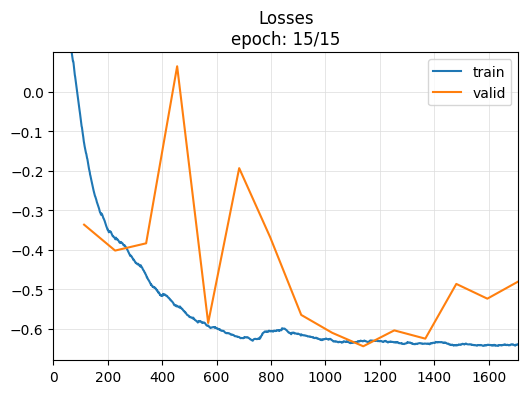

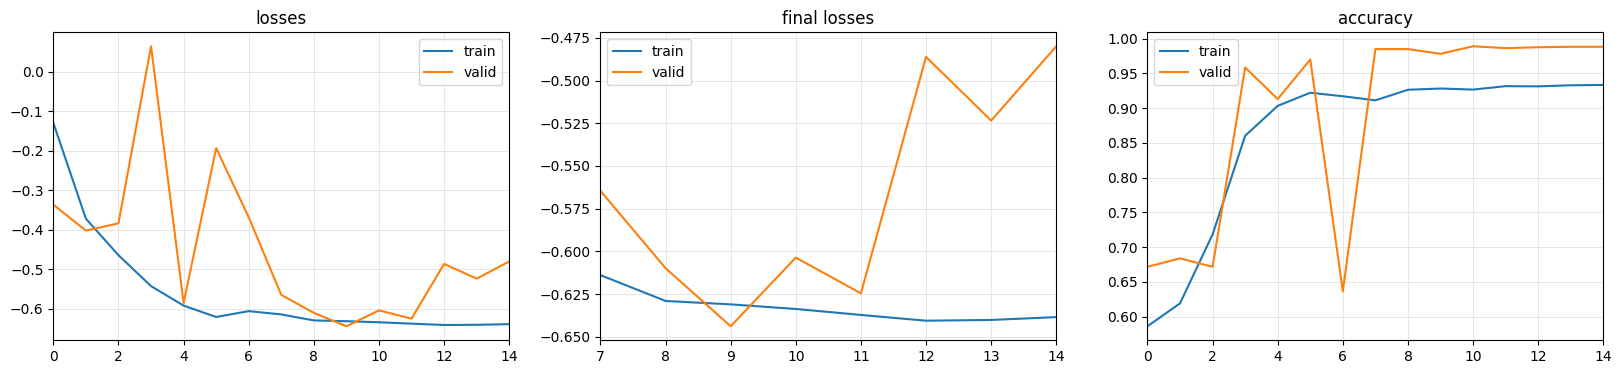

In [148]:
clf.fit_one_cycle(15, 1e-4)

In [ ]:
clf.load("har_inctime_asymloss_gamma_0.5")

In [149]:
X_all = X_all.reshape(X_all.shape[0], 1, X_all.shape[1])
X_all.shape


(8826, 1, 561)

In [150]:
# Train metrics

probas, target = clf.get_X_preds(X_all[splits[0]], y_all[splits[0]], with_decoded=False)
preds_train = probas.argmax(dim=-1)
print(classification_report(target, preds_train, digits=4))
print(confusion_matrix(target, preds_train))

              precision    recall  f1-score   support

           0     1.0000    0.9289    0.9631      6859
           1     0.5025    1.0000    0.6689       493

    accuracy                         0.9336      7352
   macro avg     0.7513    0.9644    0.8160      7352
weighted avg     0.9666    0.9336    0.9434      7352

[[6371  488]
 [   0  493]]


In [151]:
print(classification_report(y_train, preds_train, digits=4))
print(confusion_matrix(y_train, preds_train))

              precision    recall  f1-score   support

           0     0.9991    0.9998    0.9995      6366
           1     0.9990    0.9939    0.9964       986

    accuracy                         0.9990      7352
   macro avg     0.9990    0.9969    0.9979      7352
weighted avg     0.9990    0.9990    0.9990      7352

[[6365    1]
 [   6  980]]


In [152]:
probas, target = clf.get_X_preds(X_all[splits[1]], y_all[splits[1]], with_decoded=False)
preds_val = probas.argmax(dim=-1)
print(classification_report(y_val_pu, preds_val, digits=4))
print(confusion_matrix(y_val_pu, preds_val))

              precision    recall  f1-score   support

           0     0.9945    0.9277    0.9599      1369
           1     0.4975    0.9333    0.6490       105

    accuracy                         0.9281      1474
   macro avg     0.7460    0.9305    0.8045      1474
weighted avg     0.9591    0.9281    0.9378      1474

[[1270   99]
 [   7   98]]


In [153]:
print(classification_report(y_val, preds_val, digits=4))
print(confusion_matrix(y_val, preds_val))

              precision    recall  f1-score   support

           0     0.9883    0.9984    0.9933      1264
           1     0.9898    0.9286    0.9582       210

    accuracy                         0.9885      1474
   macro avg     0.9891    0.9635    0.9758      1474
weighted avg     0.9885    0.9885    0.9883      1474

[[1262    2]
 [  15  195]]


In [154]:
logits_test, target = clf.get_X_preds(X_test.reshape(X_test.shape[0], 1, X_test.shape[1]), y_test, with_decoded=False)
preds_test = logits_test.argmax(dim=-1)
print(classification_report(y_test_pu, preds_test, digits=4))
print(confusion_matrix(y_test_pu, preds_test))

              precision    recall  f1-score   support

           0     0.9922    0.9284    0.9592      1368
           1     0.4922    0.9048    0.6376       105

    accuracy                         0.9267      1473
   macro avg     0.7422    0.9166    0.7984      1473
weighted avg     0.9565    0.9267    0.9363      1473

[[1270   98]
 [  10   95]]


In [155]:
print(classification_report(y_test, preds_test, digits=4))
print(confusion_matrix(y_test, preds_test))

              precision    recall  f1-score   support

           0     0.9867    1.0000    0.9933      1263
           1     1.0000    0.9190    0.9578       210

    accuracy                         0.9885      1473
   macro avg     0.9934    0.9595    0.9756      1473
weighted avg     0.9886    0.9885    0.9883      1473

[[1263    0]
 [  17  193]]


In [156]:
# Observe the unmarked positive samples and determine in how many places the prediction matches true labels.
print("Train")
correct_preds_num_tr = (preds_train[unlabeled_idx_train] == y_train[unlabeled_idx_train]).sum()
print(f"Total number of true positive sampels:{(y_train==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_train)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tr}\n\
In percentage: {(correct_preds_num_tr/len(unlabeled_idx_train)):.4f}")
print("Test")
correct_preds_num_tst = (preds_test[unlabeled_idx_test] == y_test[unlabeled_idx_test]).sum()
print(f"Total number of true positive sampels:{(y_test==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_test)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tst}\n\
In percentage: {(correct_preds_num_tst/len(unlabeled_idx_test)):.4f}")
print("Val")
correct_preds_num_val = (preds_val[unlabeled_idx_val] == y_val[unlabeled_idx_val]).sum()
print(f"Total number of true positive sampels:{(y_val==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_val)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_val}\n\
In percentage: {(correct_preds_num_val/len(unlabeled_idx_val)):.4f}")


Train
Total number of true positive sampels:986
Total number of unmarked positive sampels: 493
Number of unmarked samples correctly predicted as positive: 487
In percentage: 0.9878
Test
Total number of true positive sampels:210
Total number of unmarked positive sampels: 105
Number of unmarked samples correctly predicted as positive: 98
In percentage: 0.9333
Val
Total number of true positive sampels:210
Total number of unmarked positive sampels: 105
Number of unmarked samples correctly predicted as positive: 97
In percentage: 0.9238


In [157]:
clf.save("har_inctime_asymloss_gamma_0.5")

Path('models/har_inctime_asymloss_gamma_0.5.pth')

# InceptionTime + (weighted) CE Loss

In [16]:
from tsai.all import *
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y_train_pu)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train_pu)
ce_weight = torch.tensor(weights, dtype=torch.float32, device=device)
criterion = nn.CrossEntropyLoss(weight=ce_weight)
print(ce_weight)
X_all = np.concatenate([X_train, X_val]).astype(np.float32)
y_all = np.concatenate([y_train_pu, y_val])

splits = (list(range(len(y_train_pu))),
          list(range(len(y_train_pu), len(y_all))))

tfms = [None, TSClassification()]
batch_tfms = TSStandardize(by_sample=True)

clf = TSClassifier(X_all, y_all, splits=splits, arch="InceptionTimePlus", arch_config=dict(fc_dropout=.2),
                   tfms=tfms, batch_tfms=batch_tfms,train_metrics=True, loss_func=criterion,
                   metrics=accuracy, cbs=ShowGraph(), wd=1e-3)


tensor([0.5359, 7.4564], device='cuda:0')


epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.505865,0.547697,0.430264,0.835821,00:06
1,0.339568,0.820312,0.230152,0.750339,00:04
2,0.250439,0.907209,0.191572,0.938263,00:04
3,0.212753,0.919682,0.367618,0.966757,00:04
4,0.182869,0.924068,0.716535,0.924695,00:04
5,0.168735,0.929276,0.359439,0.970149,00:04
6,0.152014,0.932566,0.332060,0.970149,00:04
7,0.136658,0.934073,0.465504,0.956581,00:04
8,0.132826,0.936266,0.327222,0.972185,00:04
9,0.129334,0.937637,0.324239,0.972185,00:04


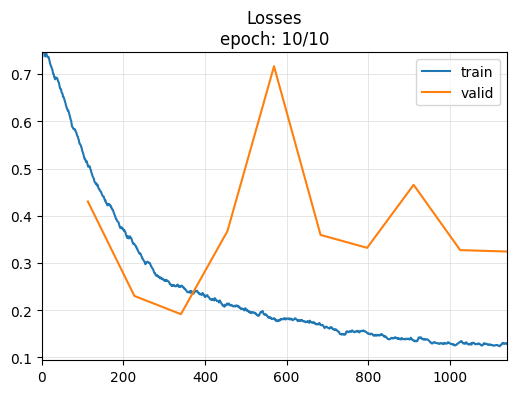

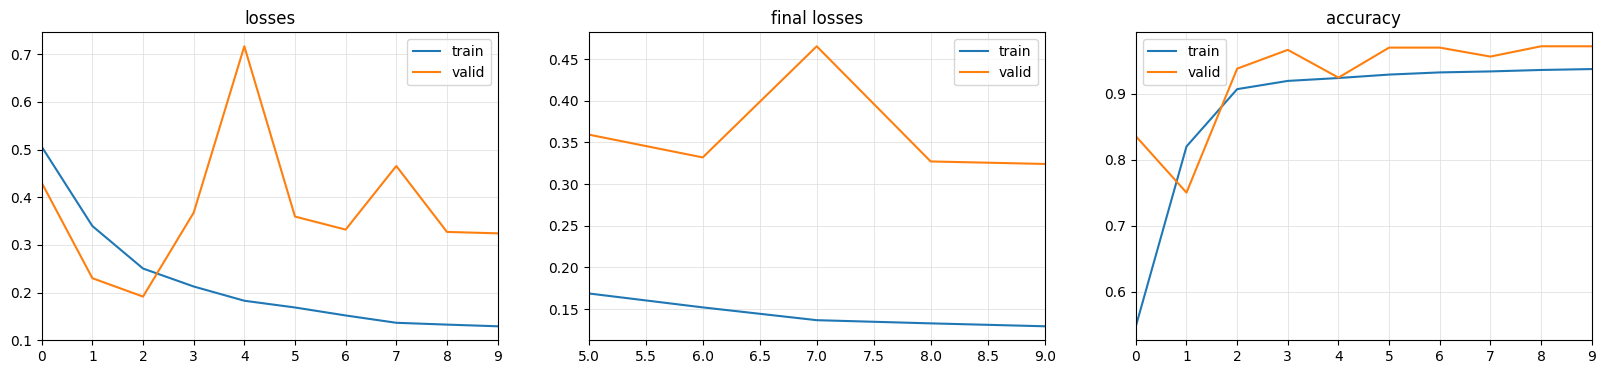

In [121]:
clf.fit_one_cycle(10, 1e-4)

In [20]:
X_all = X_all.reshape(X_all.shape[0], 1, X_all.shape[1])
X_all.shape


ValueError: cannot reshape array of size 4951386 into shape (8826,1,1)

In [ ]:
clf.load("har_inctime_wCE")

In [21]:
# Train metrics

probas, target = clf.get_X_preds(X_all[splits[0]], y_all[splits[0]], with_decoded=False)
preds_train = probas.argmax(dim=-1)
print(classification_report(target, preds_train, digits=4))
print(confusion_matrix(target, preds_train))

              precision    recall  f1-score   support

           0     1.0000    0.9322    0.9649      6859
           1     0.5146    1.0000    0.6795       493

    accuracy                         0.9368      7352
   macro avg     0.7573    0.9661    0.8222      7352
weighted avg     0.9675    0.9368    0.9458      7352

[[6394  465]
 [   0  493]]


In [22]:
print(classification_report(y_train, preds_train, digits=4))
print(confusion_matrix(y_train, preds_train))

              precision    recall  f1-score   support

           0     0.9955    0.9998    0.9976      6366
           1     0.9990    0.9706    0.9846       986

    accuracy                         0.9959      7352
   macro avg     0.9972    0.9852    0.9911      7352
weighted avg     0.9959    0.9959    0.9959      7352

[[6365    1]
 [  29  957]]


In [23]:
# Val
probas, target = clf.get_X_preds(X_all[splits[1]], y_all[splits[1]], with_decoded=False)
preds_val = probas.argmax(dim=-1)
print(classification_report(y_val_pu, preds_val, digits=4))
print(confusion_matrix(y_val_pu, preds_val))

              precision    recall  f1-score   support

           0     0.9823    0.9350    0.9581      1369
           1     0.4795    0.7810    0.5942       105

    accuracy                         0.9240      1474
   macro avg     0.7309    0.8580    0.7761      1474
weighted avg     0.9465    0.9240    0.9322      1474

[[1280   89]
 [  23   82]]


In [24]:
print(classification_report(y_val, preds_val, digits=4))
print(confusion_matrix(y_val, preds_val))

              precision    recall  f1-score   support

           0     0.9693    0.9992    0.9840      1264
           1     0.9942    0.8095    0.8924       210

    accuracy                         0.9722      1474
   macro avg     0.9817    0.9044    0.9382      1474
weighted avg     0.9728    0.9722    0.9710      1474

[[1263    1]
 [  40  170]]


In [25]:
logits_test, target = clf.get_X_preds(X_test.reshape(X_test.shape[0], 1, X_test.shape[1]), y_test, with_decoded=False)
preds_test = logits_test.argmax(dim=-1)
print(classification_report(y_test_pu, preds_test, digits=4))
print(confusion_matrix(y_test_pu, preds_test))

              precision    recall  f1-score   support

           0     0.9862    0.9371    0.9610      1368
           1     0.5029    0.8286    0.6259       105

    accuracy                         0.9294      1473
   macro avg     0.7445    0.8829    0.7935      1473
weighted avg     0.9517    0.9294    0.9371      1473

[[1282   86]
 [  18   87]]


In [26]:
print(classification_report(y_test, preds_test, digits=4))
print(confusion_matrix(y_test, preds_test))

              precision    recall  f1-score   support

           0     0.9715    1.0000    0.9856      1263
           1     1.0000    0.8238    0.9034       210

    accuracy                         0.9749      1473
   macro avg     0.9858    0.9119    0.9445      1473
weighted avg     0.9756    0.9749    0.9738      1473

[[1263    0]
 [  37  173]]


In [27]:
# Observe the unmarked positive samples and determine in how many places the prediction matches true labels.
print("Train")
correct_preds_num_tr = (preds_train[unlabeled_idx_train] == y_train[unlabeled_idx_train]).sum()
print(f"Total number of true positive sampels:{(y_train==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_train)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tr}\n\
In percentage: {(correct_preds_num_tr/len(unlabeled_idx_train)):.4f}")
print("Test")
correct_preds_num_tst = (preds_test[unlabeled_idx_test] == y_test[unlabeled_idx_test]).sum()
print(f"Total number of true positive sampels:{(y_test==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_test)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tst}\n\
In percentage: {(correct_preds_num_tst/len(unlabeled_idx_test)):.4f}")
print("Val")
correct_preds_num_val = (preds_val[unlabeled_idx_val] == y_val[unlabeled_idx_val]).sum()
print(f"Total number of true positive sampels:{(y_val==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_val)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_val}\n\
In percentage: {(correct_preds_num_val/len(unlabeled_idx_val)):.4f}")


Train
Total number of true positive sampels:986
Total number of unmarked positive sampels: 493
Number of unmarked samples correctly predicted as positive: 464
In percentage: 0.9412
Test
Total number of true positive sampels:210
Total number of unmarked positive sampels: 105
Number of unmarked samples correctly predicted as positive: 86
In percentage: 0.8190
Val
Total number of true positive sampels:210
Total number of unmarked positive sampels: 105
Number of unmarked samples correctly predicted as positive: 88
In percentage: 0.8381


In [130]:
clf.save("har_inctime_wCE")

Path('models/har_inctime_wCE.pth')

# InceptionTime + (weighted) CE Loss

In [28]:
from tsai.all import *

criterion = nn.CrossEntropyLoss()
X_all = np.concatenate([X_train, X_val]).astype(np.float32)
y_all = np.concatenate([y_train_pu, y_val])

splits = (list(range(len(y_train_pu))),
          list(range(len(y_train_pu), len(y_all))))

tfms = [None, TSClassification()]
batch_tfms = TSStandardize(by_sample=True)

clf = TSClassifier(X_all, y_all, splits=splits, arch="InceptionTimePlus", arch_config=dict(fc_dropout=.1),
                   tfms=tfms, batch_tfms=batch_tfms,train_metrics=True, loss_func=criterion,
                   metrics=accuracy, cbs=ShowGraph(), wd=1e-3)


epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.516818,0.536184,0.354667,0.857531,00:07
1,0.245983,0.933525,0.294709,0.857531,00:04
2,0.171143,0.933525,0.336359,0.857531,00:04
3,0.139965,0.931058,0.556148,0.857531,00:04
4,0.125047,0.932429,0.164367,0.910448,00:04
5,0.115735,0.941612,0.185932,0.888060,00:04
6,0.108332,0.941064,0.136077,0.938263,00:04
7,0.099472,0.951069,0.135119,0.929444,00:04
8,0.085641,0.955455,0.199975,0.892809,00:04
9,0.088420,0.956552,0.183323,0.905020,00:04


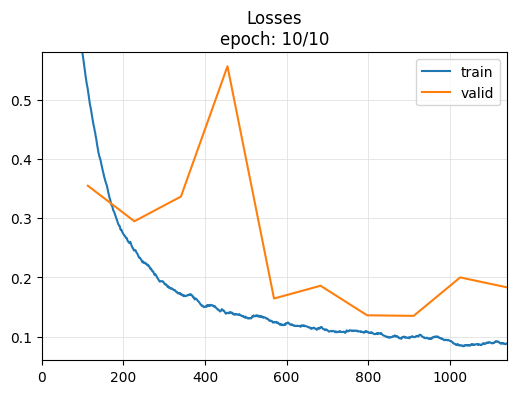

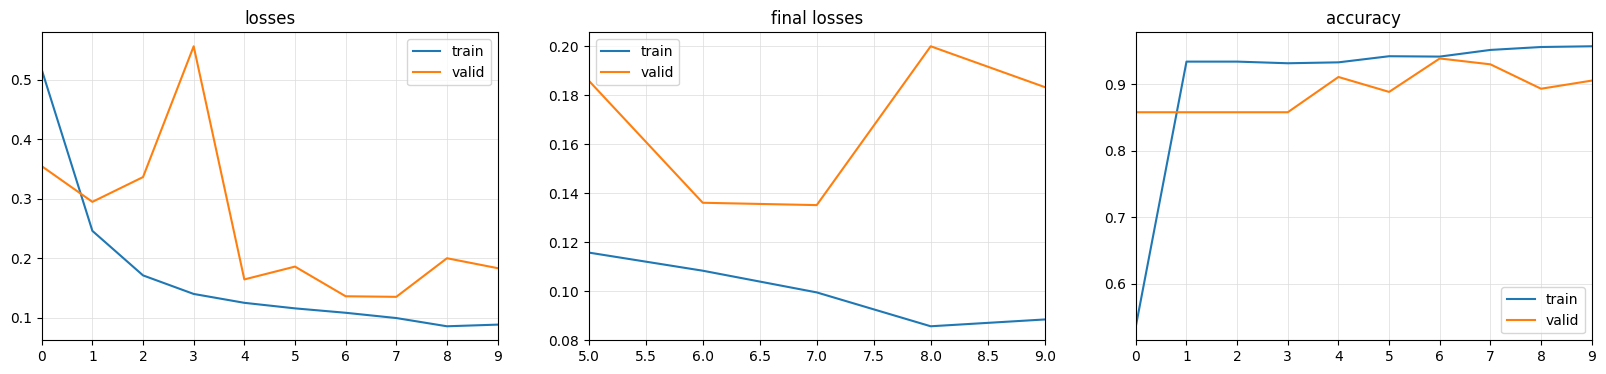

In [29]:
clf.fit_one_cycle(10, 1e-4)

In [155]:
clf.load("har_inctime_CE")

In [30]:
X_all = X_all.reshape(X_all.shape[0], 1, X_all.shape[1])
X_all.shape

(8826, 1, 561)

In [31]:
# Train metrics

probas, target = clf.get_X_preds(X_all[splits[0]], y_all[splits[0]], with_decoded=False)
preds_train = probas.argmax(dim=-1)
print(classification_report(target, preds_train, digits=4))
print(confusion_matrix(target, preds_train))

              precision    recall  f1-score   support

           0     0.9837    0.9746    0.9791      6859
           1     0.6871    0.7748    0.7283       493

    accuracy                         0.9612      7352
   macro avg     0.8354    0.8747    0.8537      7352
weighted avg     0.9638    0.9612    0.9623      7352

[[6685  174]
 [ 111  382]]


In [32]:
print(classification_report(y_train, preds_train, digits=4))
print(confusion_matrix(y_train, preds_train))

              precision    recall  f1-score   support

           0     0.9367    1.0000    0.9673      6366
           1     1.0000    0.5639    0.7211       986

    accuracy                         0.9415      7352
   macro avg     0.9684    0.7819    0.8442      7352
weighted avg     0.9452    0.9415    0.9343      7352

[[6366    0]
 [ 430  556]]


In [33]:
# Val
probas, target = clf.get_X_preds(X_all[splits[1]], y_all[splits[1]], with_decoded=False)
preds_val = probas.argmax(dim=-1)
print(classification_report(y_val_pu, preds_val, digits=4))
print(confusion_matrix(y_val_pu, preds_val))

              precision    recall  f1-score   support

           0     0.9494    0.9737    0.9614      1369
           1     0.4857    0.3238    0.3886       105

    accuracy                         0.9274      1474
   macro avg     0.7176    0.6488    0.6750      1474
weighted avg     0.9164    0.9274    0.9206      1474

[[1333   36]
 [  71   34]]


In [34]:
print(classification_report(y_val, preds_val, digits=4))
print(confusion_matrix(y_val, preds_val))

              precision    recall  f1-score   support

           0     0.9003    1.0000    0.9475      1264
           1     1.0000    0.3333    0.5000       210

    accuracy                         0.9050      1474
   macro avg     0.9501    0.6667    0.7238      1474
weighted avg     0.9145    0.9050    0.8838      1474

[[1264    0]
 [ 140   70]]


In [35]:
logits_test, target = clf.get_X_preds(X_test.reshape(X_test.shape[0], 1, X_test.shape[1]), y_test, with_decoded=False)
preds_test = logits_test.argmax(dim=-1)
print(classification_report(y_test_pu, preds_test, digits=4))
print(confusion_matrix(y_test_pu, preds_test))

              precision    recall  f1-score   support

           0     0.9484    0.9817    0.9648      1368
           1     0.5614    0.3048    0.3951       105

    accuracy                         0.9335      1473
   macro avg     0.7549    0.6432    0.6799      1473
weighted avg     0.9209    0.9335    0.9242      1473

[[1343   25]
 [  73   32]]


In [36]:
print(classification_report(y_test, preds_test, digits=4))
print(confusion_matrix(y_test, preds_test))

              precision    recall  f1-score   support

           0     0.8919    1.0000    0.9429      1263
           1     1.0000    0.2714    0.4270       210

    accuracy                         0.8961      1473
   macro avg     0.9460    0.6357    0.6849      1473
weighted avg     0.9074    0.8961    0.8693      1473

[[1263    0]
 [ 153   57]]


In [37]:
# Observe the unmarked positive samples and determine in how many places the prediction matches true labels.
print("Train")
correct_preds_num_tr = (preds_train[unlabeled_idx_train] == y_train[unlabeled_idx_train]).sum()
print(f"Total number of true positive sampels:{(y_train==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_train)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tr}\n\
In percentage: {(correct_preds_num_tr/len(unlabeled_idx_train)):.4f}")
print("Test")
correct_preds_num_tst = (preds_test[unlabeled_idx_test] == y_test[unlabeled_idx_test]).sum()
print(f"Total number of true positive sampels:{(y_test==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_test)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tst}\n\
In percentage: {(correct_preds_num_tst/len(unlabeled_idx_test)):.4f}")
print("Val")
correct_preds_num_val = (preds_val[unlabeled_idx_val] == y_val[unlabeled_idx_val]).sum()
print(f"Total number of true positive sampels:{(y_val==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_val)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_val}\n\
In percentage: {(correct_preds_num_val/len(unlabeled_idx_val)):.4f}")


Train
Total number of true positive sampels:986
Total number of unmarked positive sampels: 493
Number of unmarked samples correctly predicted as positive: 174
In percentage: 0.3529
Test
Total number of true positive sampels:210
Total number of unmarked positive sampels: 105
Number of unmarked samples correctly predicted as positive: 25
In percentage: 0.2381
Val
Total number of true positive sampels:210
Total number of unmarked positive sampels: 105
Number of unmarked samples correctly predicted as positive: 36
In percentage: 0.3429


In [40]:
clf.save("har_inctime_CE")

Path('models/har_inctime_CE.pth')

# InceptionTime + PU Loss

In [211]:
from tsai.all import *

criterion = PULossWrapped(prior=2*positive_prior, nnPU=True)
#criterion = PUAsymLoss_CE(gamma=0.5)


X_all = np.concatenate([X_train, X_val]).astype(np.float32)
y_all = np.concatenate([y_train_pu, y_val])

splits = (list(range(len(y_train_pu))),
          list(range(len(y_train_pu), len(y_all))))

tfms = [None, TSClassification()]
batch_tfms = TSStandardize(by_sample=True)

clf = TSClassifier(X_all, y_all, splits=splits, arch="InceptionTimePlus", #arch_config=dict(fc_dropout=0.3),
                   tfms=tfms, batch_tfms=batch_tfms,train_metrics=True, loss_func=criterion,
                   metrics=accuracy, cbs=ShowGraph(), wd=1e-3)


epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.391721,0.807429,0.241215,0.892809,00:04
1,0.206795,0.863898,0.930728,0.142469,00:04
2,0.120246,0.902001,0.036678,0.901628,00:04
3,0.107495,0.905291,0.037529,0.895522,00:04
4,0.083513,0.911458,0.020291,0.891452,00:04
5,0.087499,0.902138,0.028475,0.970828,00:04
6,0.075648,0.914474,0.045145,0.965400,00:04
7,0.062760,0.912281,0.043249,0.960651,00:05
8,0.066200,0.914611,0.041742,0.974898,00:04
9,0.060961,0.926124,0.040174,0.976934,00:04


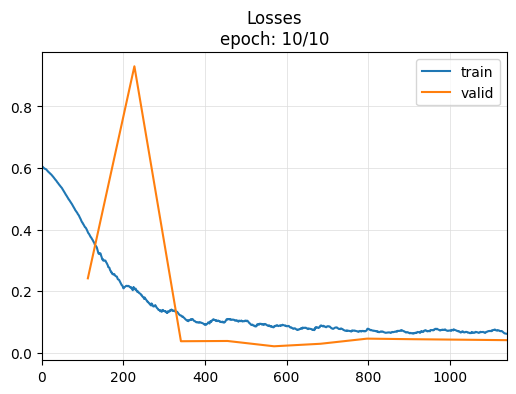

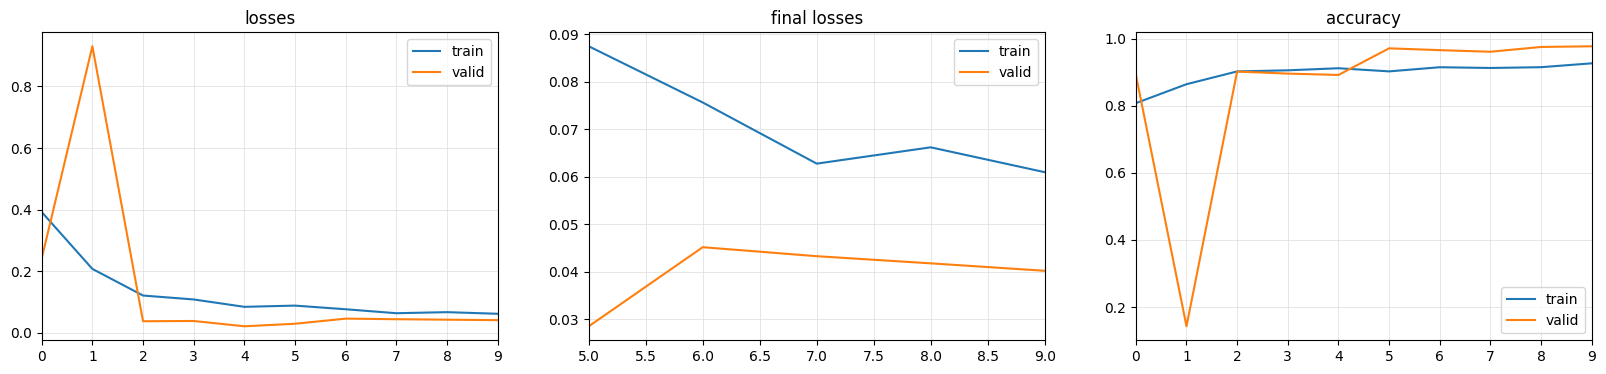

In [198]:
clf.fit_one_cycle(10, 1e-4)

In [212]:
clf.load("har_inctime_nnPU")

In [213]:
X_all = X_all.reshape(X_all.shape[0], 1, X_all.shape[1])
X_all.shape


(8826, 1, 561)

In [214]:
# Train metrics

probas, target = clf.get_X_preds(X_all[splits[0]], y_all[splits[0]], with_decoded=False)
preds_train = probas.argmax(dim=-1)
print(classification_report(target, preds_train, digits=4))
print(confusion_matrix(target, preds_train))

              precision    recall  f1-score   support

           0     0.9995    0.9195    0.9579      6859
           1     0.4702    0.9939    0.6384       493

    accuracy                         0.9245      7352
   macro avg     0.7349    0.9567    0.7981      7352
weighted avg     0.9640    0.9245    0.9364      7352

[[6307  552]
 [   3  490]]


In [215]:
print(classification_report(y_train, preds_train, digits=4))
print(confusion_matrix(y_train, preds_train))

              precision    recall  f1-score   support

           0     0.9986    0.9898    0.9942      6366
           1     0.9376    0.9909    0.9635       986

    accuracy                         0.9899      7352
   macro avg     0.9681    0.9903    0.9788      7352
weighted avg     0.9904    0.9899    0.9901      7352

[[6301   65]
 [   9  977]]


In [216]:
probas, target = clf.get_X_preds(X_all[splits[1]], y_all[splits[1]], with_decoded=False)
preds_val = probas.argmax(dim=-1)
print(classification_report(y_val_pu, preds_val, digits=4))
print(confusion_matrix(y_val_pu, preds_val))

              precision    recall  f1-score   support

           0     0.9898    0.9255    0.9566      1369
           1     0.4742    0.8762    0.6154       105

    accuracy                         0.9220      1474
   macro avg     0.7320    0.9008    0.7860      1474
weighted avg     0.9531    0.9220    0.9323      1474

[[1267  102]
 [  13   92]]


In [217]:
print(classification_report(y_val, preds_val, digits=4))
print(confusion_matrix(y_val, preds_val))

              precision    recall  f1-score   support

           0     0.9805    0.9929    0.9866      1264
           1     0.9536    0.8810    0.9158       210

    accuracy                         0.9769      1474
   macro avg     0.9670    0.9369    0.9512      1474
weighted avg     0.9766    0.9769    0.9765      1474

[[1255    9]
 [  25  185]]


In [218]:
logits_test, target = clf.get_X_preds(X_test.reshape(X_test.shape[0], 1, X_test.shape[1]), y_test, with_decoded=False)
preds_test = logits_test.argmax(dim=-1)
print(classification_report(y_test_pu, preds_test, digits=4))
print(confusion_matrix(y_test_pu, preds_test))

              precision    recall  f1-score   support

           0     0.9891    0.9284    0.9578      1368
           1     0.4815    0.8667    0.6190       105

    accuracy                         0.9240      1473
   macro avg     0.7353    0.8975    0.7884      1473
weighted avg     0.9529    0.9240    0.9336      1473

[[1270   98]
 [  14   91]]


In [219]:
print(classification_report(y_test, preds_test, digits=4))
print(confusion_matrix(y_test, preds_test))

              precision    recall  f1-score   support

           0     0.9790    0.9952    0.9870      1263
           1     0.9683    0.8714    0.9173       210

    accuracy                         0.9776      1473
   macro avg     0.9736    0.9333    0.9522      1473
weighted avg     0.9774    0.9776    0.9771      1473

[[1257    6]
 [  27  183]]


In [220]:
# Observe the unmarked positive samples and determine in how many places the prediction matches true labels.
print("Train")
correct_preds_num_tr = (preds_train[unlabeled_idx_train] == y_train[unlabeled_idx_train]).sum()
print(f"Total number of true positive sampels:{(y_train==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_train)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tr}\n\
In percentage: {(correct_preds_num_tr/len(unlabeled_idx_train)):.4f}")
print("Test")
correct_preds_num_tst = (preds_test[unlabeled_idx_test] == y_test[unlabeled_idx_test]).sum()
print(f"Total number of true positive sampels:{(y_test==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_test)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tst}\n\
In percentage: {(correct_preds_num_tst/len(unlabeled_idx_test)):.4f}")
print("Val")
correct_preds_num_val = (preds_val[unlabeled_idx_val] == y_val[unlabeled_idx_val]).sum()
print(f"Total number of true positive sampels:{(y_val==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_val)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_val}\n\
In percentage: {(correct_preds_num_val/len(unlabeled_idx_val)):.4f}")


Train
Total number of true positive sampels:986
Total number of unmarked positive sampels: 493
Number of unmarked samples correctly predicted as positive: 487
In percentage: 0.9878
Test
Total number of true positive sampels:210
Total number of unmarked positive sampels: 105
Number of unmarked samples correctly predicted as positive: 92
In percentage: 0.8762
Val
Total number of true positive sampels:210
Total number of unmarked positive sampels: 105
Number of unmarked samples correctly predicted as positive: 93
In percentage: 0.8857


In [208]:
clf.save("har_inctime_nnPU")

Path('models/har_inctime_nnPU.pth')